In [1]:
import numpy as np
import pandas as pd
import healpy as hp
%config InlineBackend.figure_format = 'retina'
from DS_Planck_Unet import west_val, east_val
from matplotlib import pyplot as plt
from DS_Planck_Unet import load_planck_model, draw_pic_with_mask, draw_pic, val_pix
from DS_healpix_fragmentation import *
from DS_data_transformation import pic2fits, normalize
from DS_detector import *
import os
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
from DS_data_transformation import normalize
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from scipy.special import logit
from DS_models_stat import stat_orig_cats
from DS_detector import rematch_cat
from matplotlib import cm
from matplotlib.ticker import LinearLocator


In [ ]:
a = np.zeros(hp.nside2npix(2))
a[west_val] = 1
a[east_val] = 2

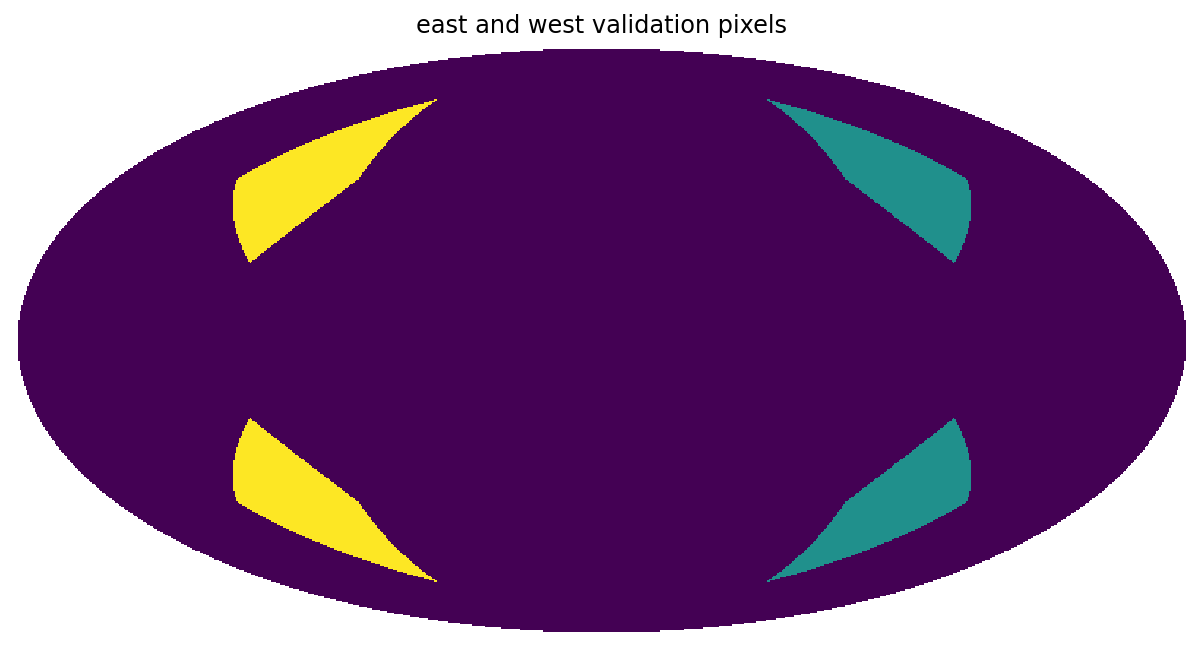

In [7]:
hp.mollview(a, nest=True, title='east and west validation pixels', cbar=False)

In [2]:
pix2 = east_val[0]
print(pix2, 'pix2')
cat = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_rot28_thr0.1_step8_no_fn.csv')
cat = cat[cat['status'] == 'tp']
cat = cat[cat['catalog'] == 'planck_z']
cat = cat[radec2pix(cat['tRA'], cat['tDEC'], 2) == pix2]
cat.index = np.arange(len(cat))
cat['pix'] = radec2pix(cat['tRA'], cat['tDEC'], 2**11)
print(cat.shape, 'cluster')
size = 16
coords = np.stack([cat['tRA'], cat['tDEC']]).T
print(coords.shape, 'coords')
matr = one_pixel_fragmentation(2, pix2, 10)
mdict = matr2dict(matr)
cat['x'] = 0
cat['y'] = 0

38 pix2
(48, 16) cluster
(48, 2) coords


In [3]:
all_model = load_planck_model('/home/rt2122/Models/all_found/all_found.ep0034-vl0.009741-l0.008339.hdf5')

In [4]:
all_data_dict = gen_pics_for_detection(pix2, all_model, step=4, only=True, data_type=np.float)
all_connected = connect_masks(all_data_dict['ans'], all_data_dict['pic_idx'], data_type=np.float16)
del all_data_dict

In [32]:
pic, mask = draw_pic_with_mask(None, coords, matr=matr)
ypic = draw_pic(matr, y=True)
cm1 = sns.light_palette("red", as_cmap=True)
cm2 = sns.light_palette("gray", as_cmap=True)
def pic9(idx): 
    print(cat.iloc[idx])
    x_cl, y_cl = mdict[radec2pix(*coords[idx], 2**11)]
    sm_pic = pic[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    sm_ypic = ypic[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    sm_mask = mask[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    sm_matr = matr[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    sm_mdict = matr2dict(sm_matr)
    sm_all = all_connected[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    s = 100
    
    x_dr = []
    y_dr = []
    for p in radec2pix(coords[:, 0], coords[:, 1], 2**11):
        if p in sm_mdict:
            x, y = sm_mdict[p]
            x_dr.append(x)
            y_dr.append(y)
    _, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.001)
    
    pic_dict = {6 : logit(sm_all), 7 : sm_ypic, 8:sm_mask}
    
   # val_min = [None, None, None, 0, 3, 6]
    #val_max= [None, None, None, 5, 25, 35]
    val_min=[None]*6
    val_max=[None]*6
    
    for i in range(3):
        for j in range(3):
            if 3*i+j < 6:
                ax[i][j].imshow(sm_pic[:,:,3*i+j], vmin=val_min[3*i+j], vmax=val_max[3*i+j])#, cmap=cmg)
                ax[i][j].set_xlabel(3*i+j)
                print(3*i+j, sm_pic[:,:,3*i+j].min(), sm_pic[:,:,3*i+j].max())
                #ax[i][j].imshow(sm_mask[:,:,0], alpha=0.5*sm_mask[:,:,0].astype(float), cmap=cm2)
            else:
                ax[i][j].imshow(pic_dict[3*i+j][:,:,0])#, cmap=cmg)
                #ax[i][j].imshow(sm_mask[:,:,0], alpha=0.5*sm_mask[:,:,0].astype(float), cmap=cm2)
    for i in range(3):
        for j in range(3):
            #for k in range(len(cat)):
            #    x = cat['x'][i]
            #    y = cat['y'][i]
            #    if x in range(2 * size) and y in range(2 * size):
                ax[i][j].scatter(y_dr, x_dr, marker='x', c='r', s=s)
            
    ax[2][1].set_xlabel('y map')
    ax[2][0].set_xlabel('Best model prediction')
    ax[2][2].set_xlabel('Ground truth mask')


RA           2.55509
DEC           6.6322
area              12
min_rad     0.998688
max_rad      3.16757
mean_rad      2.0952
min_pred    0.101113
max_pred    0.278512
tRA           2.5584
tDEC         6.63386
status            tp
catalog     planck_z
M500         4.79848
z           0.291234
pix2         val_pix
pix         39911248
x                  0
y                  0
Name: 6, dtype: object
0 -2.2042324542999268 2.2129175662994385
1 -1.9698359966278076 2.038890838623047
2 -1.5550154447555542 3.209322214126587
3 0.08552980422973633 11.507102012634277
4 3.5034220218658447 30.528600692749023
5 6.7982916831970215 45.377281188964844


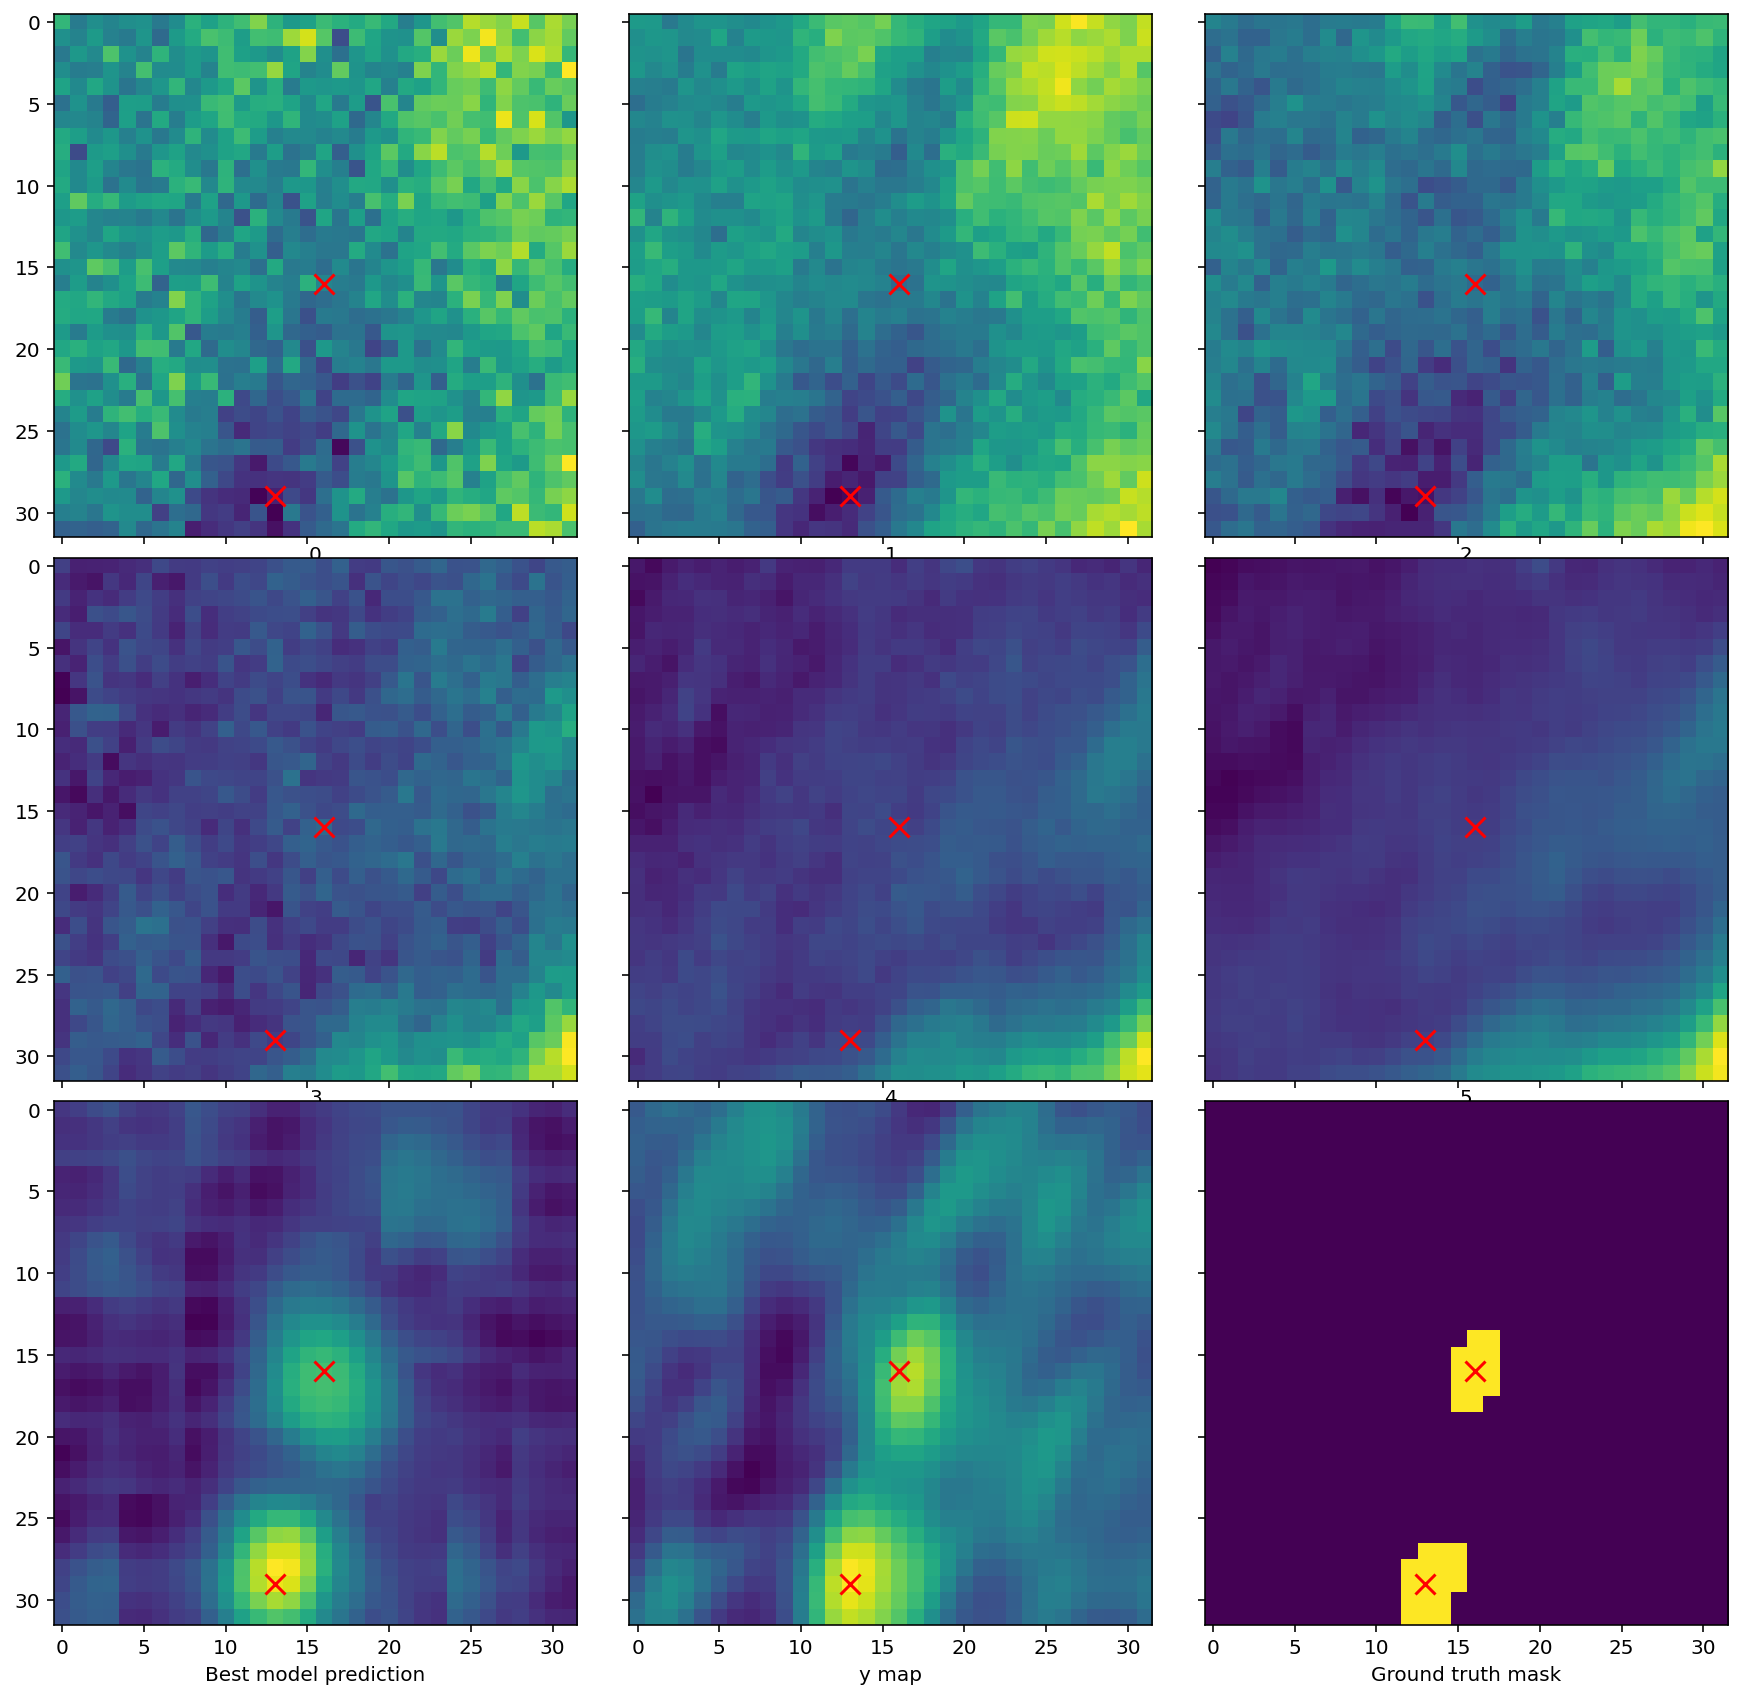

In [33]:
pic9(6)

In [31]:
def plot_history(hist_file, loss_tick=None, cut_eps=[0, -1], major_xticks=None):
    import pickle
    import pandas as pd
    import numpy as np
    from matplotlib import pyplot as plt
    
    hist = None
    with open(hist_file, 'rb') as f:
        hist = pickle.load(f)
        hist = pd.DataFrame(hist, index=np.arange(1, len(hist['loss']) + 1))
    _, ax = plt.subplots(1, 2, figsize=(18,5))
    
    hist = hist.iloc[cut_eps[0]:cut_eps[1]]
    
    line, = ax[0].plot(hist.index, hist['loss'], 'co-')
    line.set_label('Loss')
    line, = ax[0].plot(hist.index, hist['val_loss'], 'co-', alpha=0.5)
    line.set_label('Validation loss')
    
    names = {'iou' : 'IoU', 'dice' : 'Dice'}
    for c, metr in zip('rb', ['iou', 'dice']):
        line, = ax[1].plot(hist.index, hist[metr], c+'o-')
        line.set_label(names[metr])
        line, = ax[1].plot(hist.index, hist['val_'+metr], c+'o-', alpha=0.5)
        line.set_label('Validation ' + names[metr])
    
    if major_xticks is None:
        major_xticks = hist.index[4::5]
    
    for i in range(2):
        ax[i].legend()
        ax[i].set_xticks(hist.index, minor=True)
        ax[i].set_xticks(major_xticks)
        ax[i].grid(True, axis='both', which='major')
        ax[i].grid(True, axis='both', which='minor', alpha=0.2)
        ax[i].set_xlabel('Epochs')
    if not (loss_tick is None):
        ax[0].set_yticks(loss_tick[::5])
        ax[0].set_yticks(loss_tick, minor=True)
    ax[0].set_ylabel('Binary crossentropy')
    ax[1].set_ylabel('IoU / Dice')

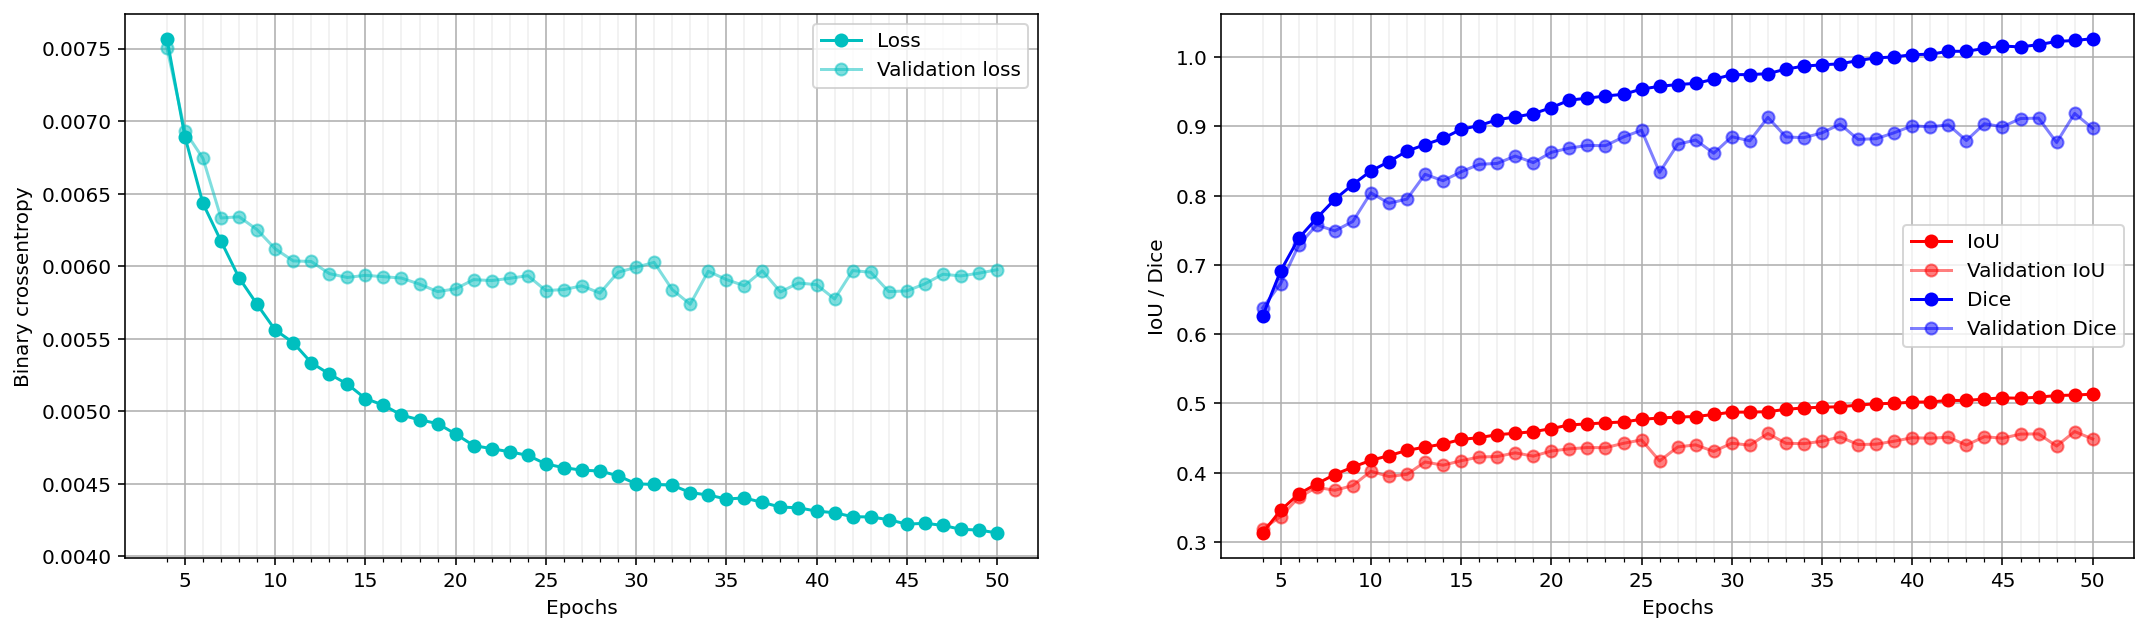

In [35]:
plot_history('/home/rt2122/Models/pz_only_rot/pz_only_rot.ep1-50.history', cut_eps=[3, 50], major_xticks=np.arange(5, 51, 5))

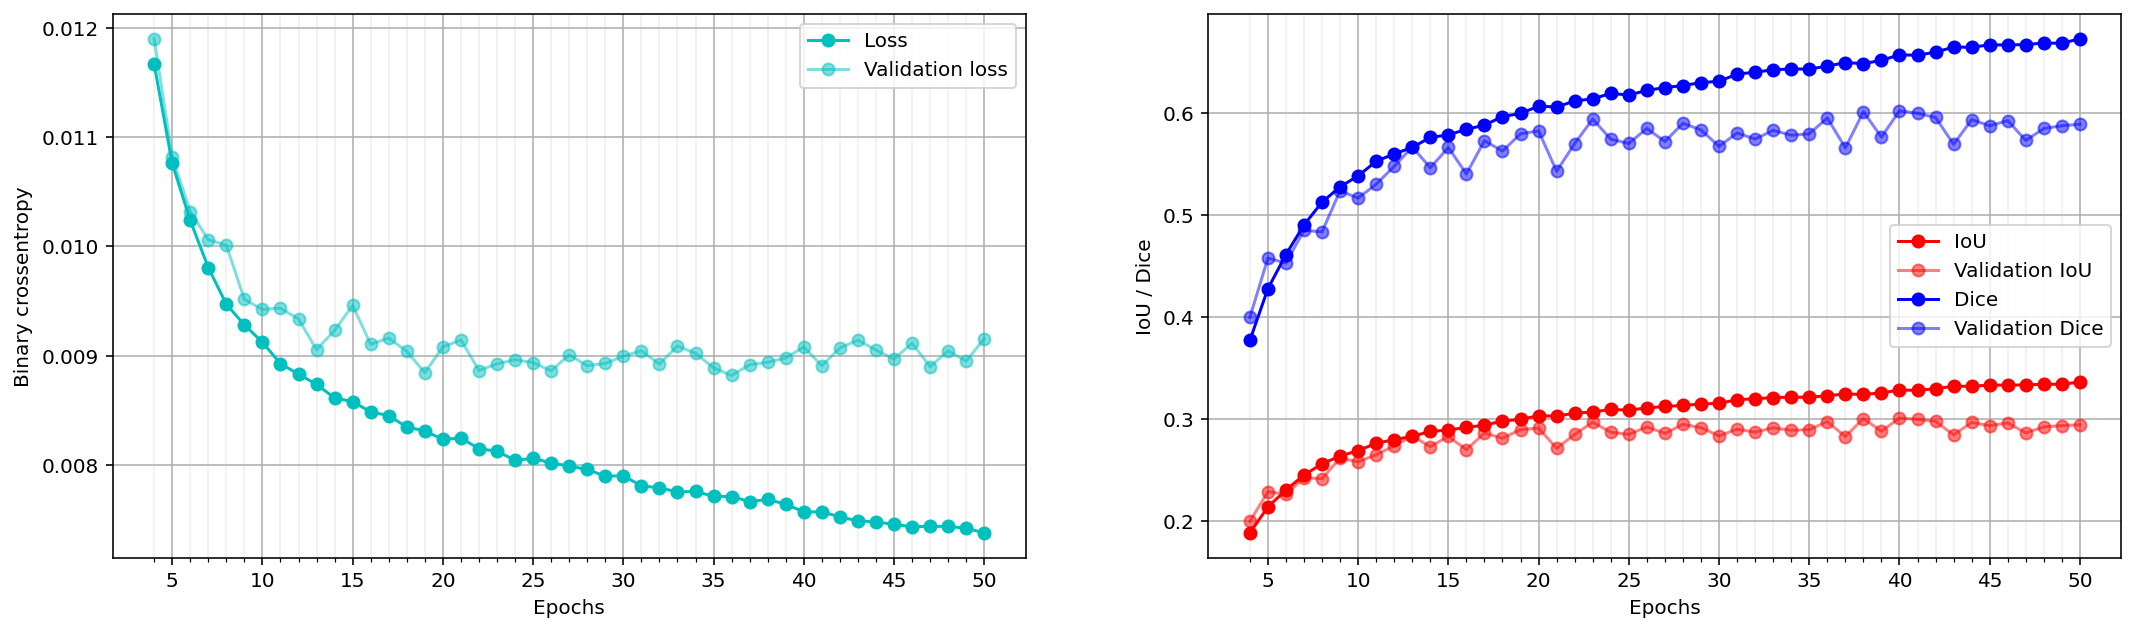

In [36]:
plot_history('/home/rt2122/Models/act_found2/act_found2.ep1-50.history', cut_eps=[3, 50], major_xticks=np.arange(5, 51, 5))

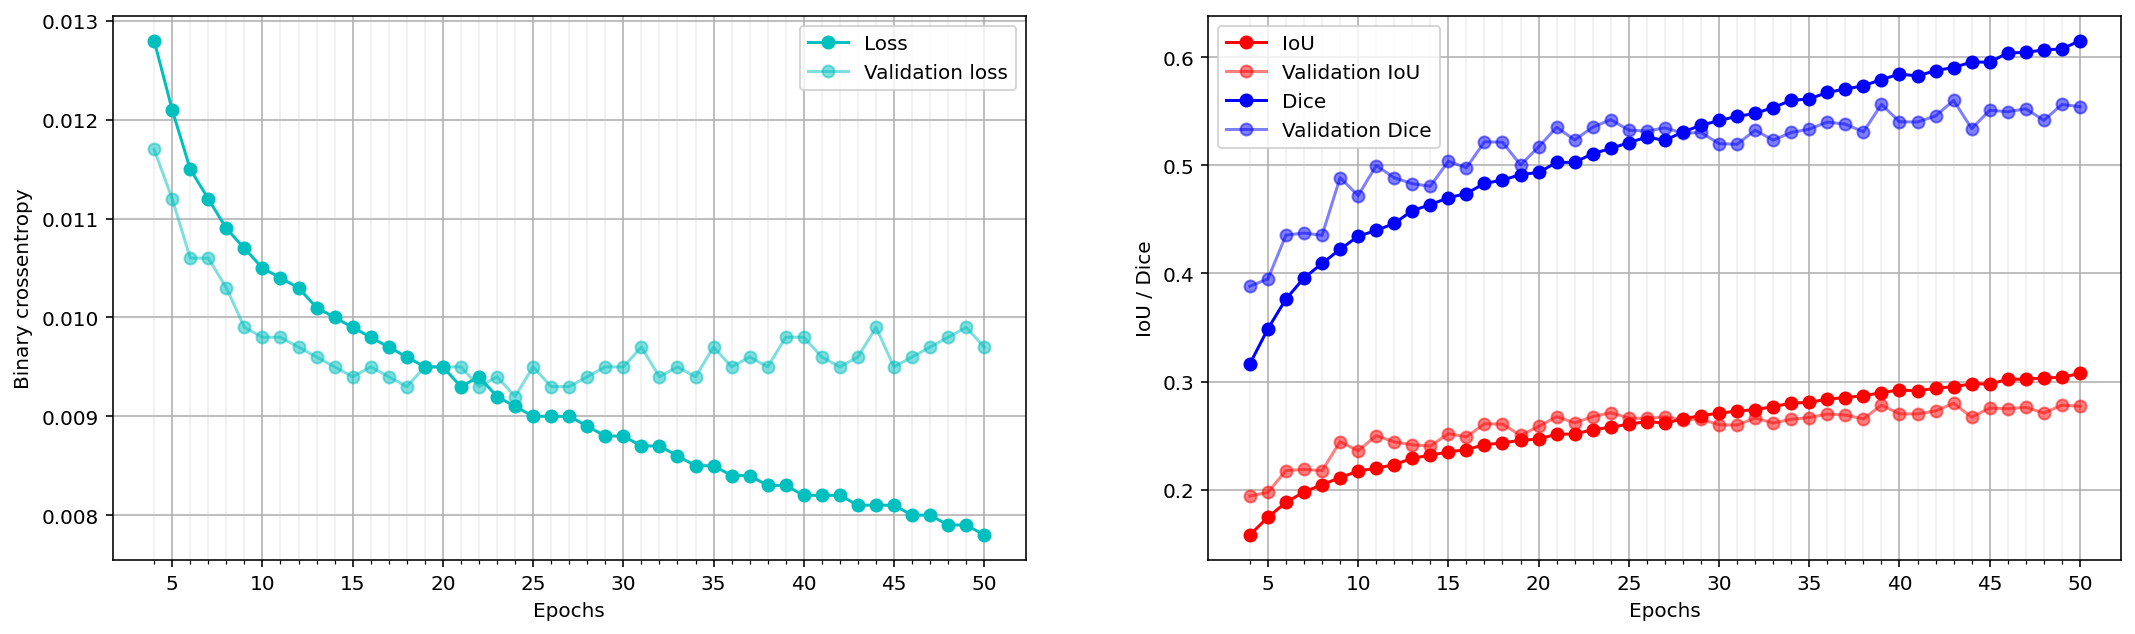

In [37]:
plot_history('/home/rt2122/Models/all_found4/all_found4.ep1-50.history', cut_eps=[3, 50], major_xticks=np.arange(5, 51, 5)) #здесь валидация - западная часть

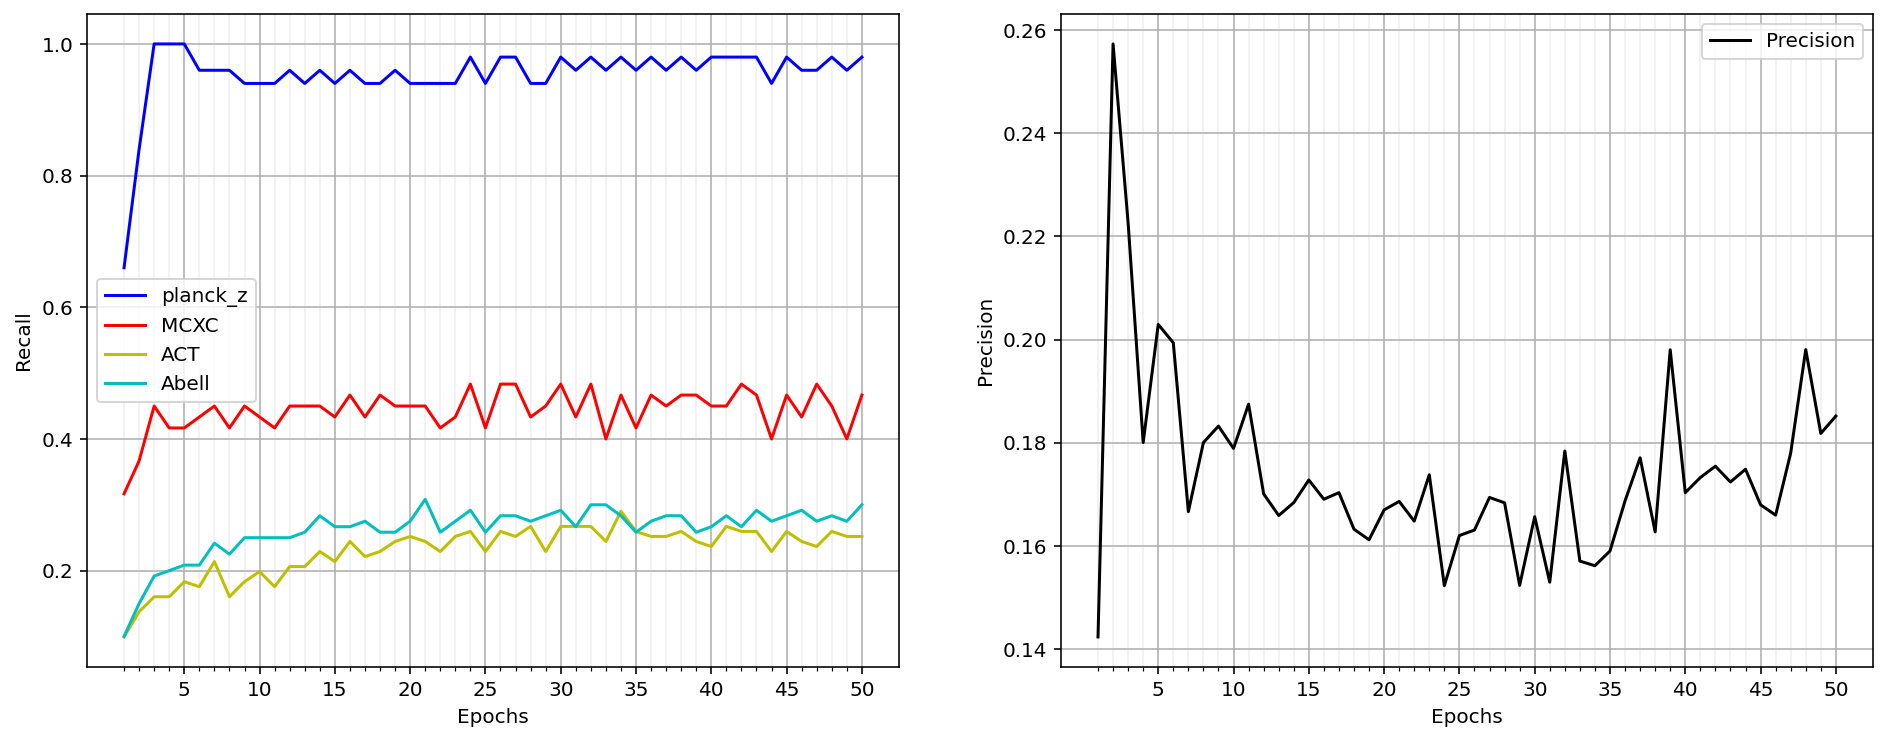

In [23]:
recall_df = pd.read_csv('/home/rt2122/L/check/all_found4_recall.csv', index_col='epoch')
_, ax = plt.subplots(1, 2, figsize=(16, 6))
for c, name in zip('brycg', ['planck_z', 'MCXC', 'ACT', 'Abell']):
    s, = ax[0].plot(recall_df.index, recall_df[name], c=c)
    s.set_label(name)
ax[0].set_ylabel('Recall')
s, = ax[1].plot(recall_df.index, recall_df['precision'], c='k')
s.set_label('Precision')
ax[1].set_ylabel('Precision')

for i in range(2):
    ax[i].set_xlabel('Epochs')
    ax[i].set_xticks(recall_df.index, minor=True)
    ax[i].set_xticks(recall_df.index[4::5])
    ax[i].grid(True, axis='both', which='major')
    ax[i].grid(True, axis='both', which='minor', alpha=0.2)
    ax[i].legend()

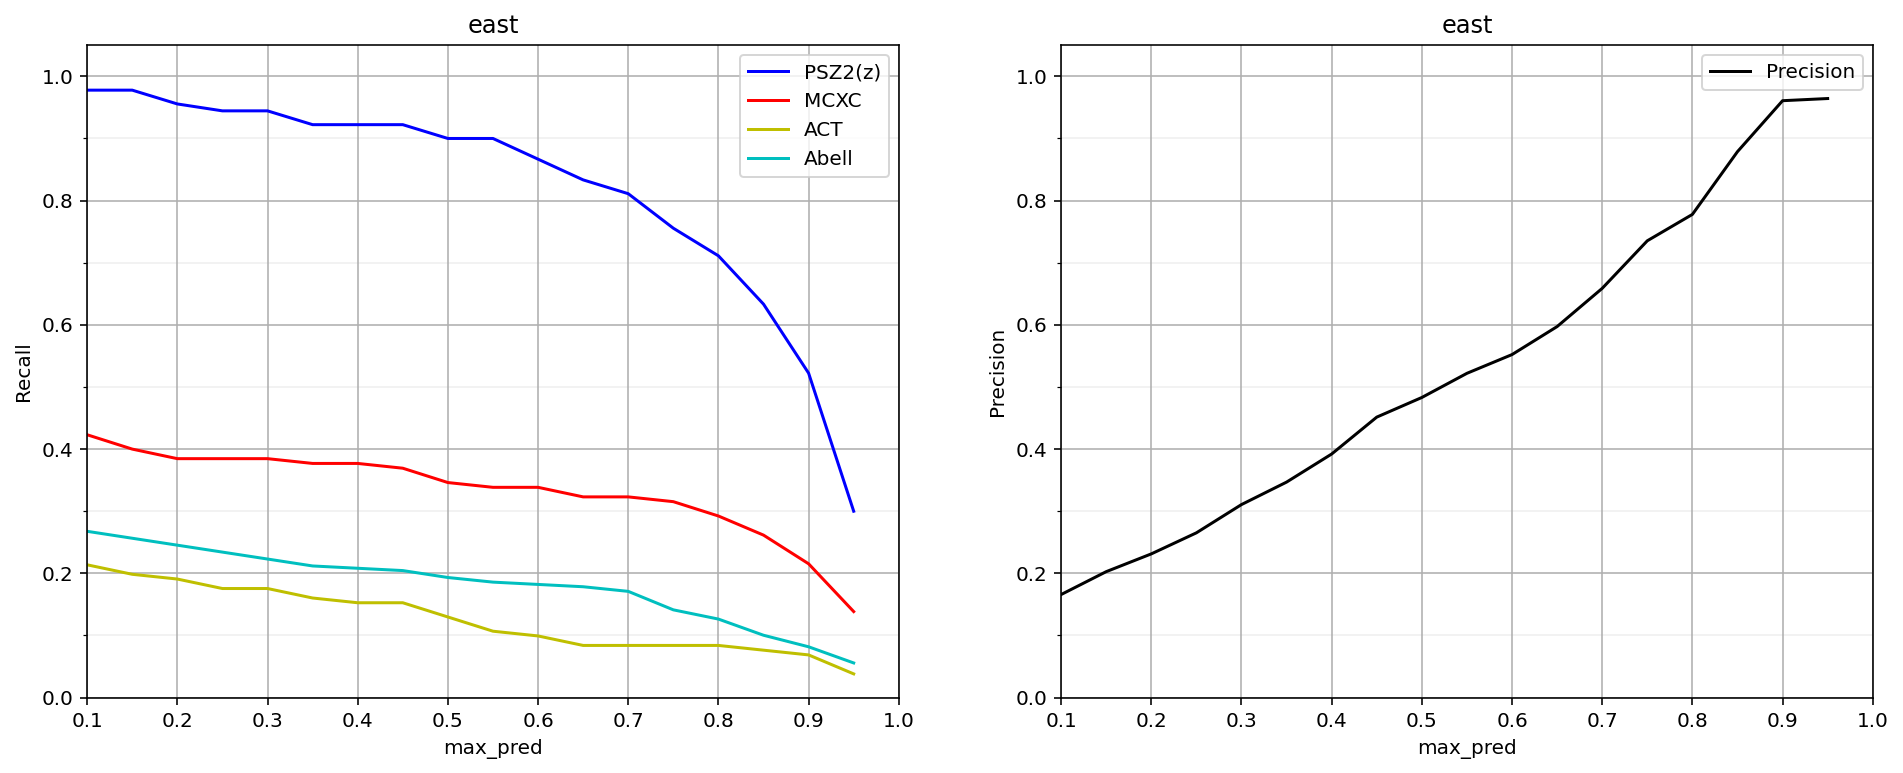

In [51]:
recall_df = pd.read_csv('/home/rt2122/L/check/all_found34_recall_max_pred_pixe.csv', index_col='max_pred')
_, ax = plt.subplots(1, 2, figsize=(16, 6))
for c, name in zip('brycg', ['planck_z', 'MCXC', 'ACT', 'Abell']):
    s, = ax[0].plot(recall_df.index, recall_df[name], c=c)
    if name == 'planck_z':
        name = 'PSZ2(z)'
    s.set_label(name)
ax[0].set_ylabel('Recall')
s, = ax[1].plot(recall_df.index, recall_df['precision'], c='k')
s.set_label('Precision')
ax[1].set_ylabel('Precision')

for i in range(2):
    ax[i].set_xlim(0.1, 1)
    ax[i].set_ylim(0, 1.05)
    ax[i].set_xlabel('max_pred')
    ax[i].set_title('east')
    ax[i].set_xticks(np.arange(0.1, 1, 0.1), minor=True)
    ax[i].set_yticks(np.arange(0.1, 1, 0.1), minor=True)
    #ax[i].set_xticks(recall_df.index[4::5)
    ax[i].grid(True, axis='both', which='major')
    ax[i].grid(True, axis='both', which='minor', alpha=0.2)
    ax[i].legend()

No handles with labels found to put in legend.


1513

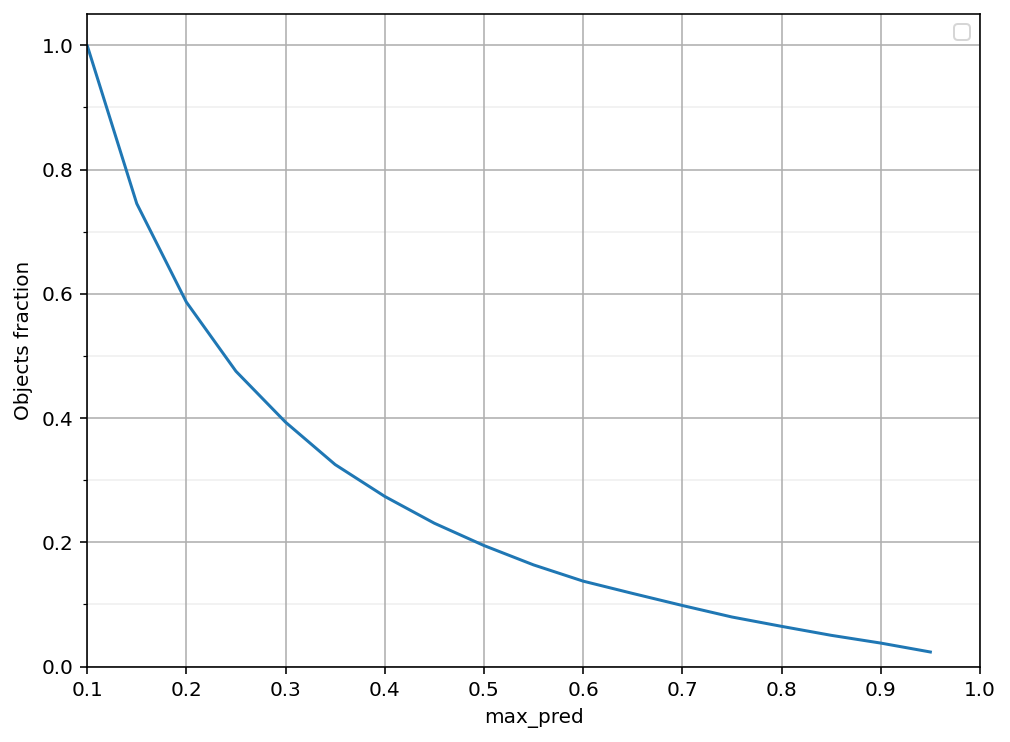

In [59]:
df = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv')
max_preds = np.arange(0, 1, 0.05)
ratio = [np.count_nonzero(df['max_pred'] >= max_pred) / len(df) for max_pred in max_preds]
_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(max_preds, ratio)
ax.set_xlim(0.1, 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel('max_pred')
ax.set_ylabel('Objects fraction')
ax.set_xticks(np.arange(0.1, 1, 0.1), minor=True)
ax.set_yticks(np.arange(0.1, 1, 0.1), minor=True)
ax.grid(True, axis='both', which='major')
ax.grid(True, axis='both', which='minor', alpha=0.2)
ax.legend()
np.count_nonzero(df['max_pred'] >= 0.8)

No handles with labels found to put in legend.


1513

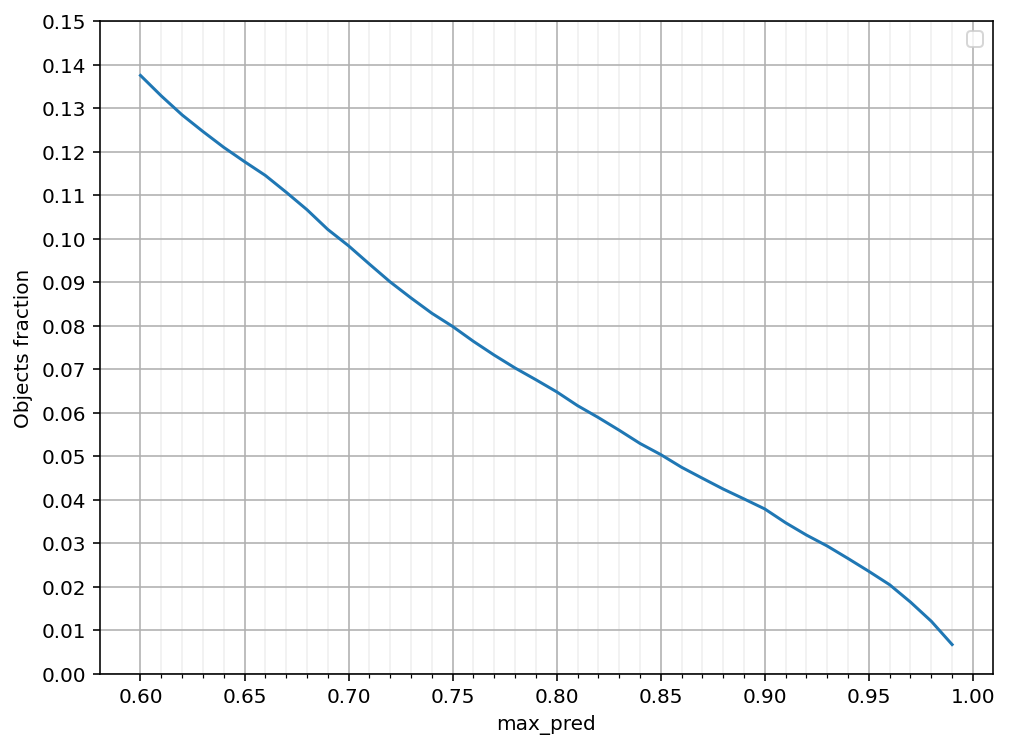

In [58]:
max_preds = np.arange(0.6, 1, 0.01)
ratio = [np.count_nonzero(df['max_pred'] >= max_pred) / len(df) for max_pred in max_preds]
_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(max_preds, ratio)
ax.set_xlabel('max_pred')
ax.set_ylabel('Objects fraction')
ax.set_xticks(max_preds, minor=True)
ax.set_ylim(0, 0.15)
ax.set_yticks(np.arange(0, 0.16, 0.01))
ax.grid(True, axis='both', which='major')
ax.grid(True, axis='both', which='minor', alpha=0.2)
ax.legend()
np.count_nonzero(df['max_pred'] >= 0.8)

In [33]:
def make_histogram(ax, tp, fp, n_bins, label1='Yes matches', label2='No matches'):
    ax.hist(tp, n_bins, color='r', log=True, histtype='step', label=label1)
    ax.hist(fp, n_bins, color='b', log=True, histtype='step', label=label2)
    ax.legend()

In [49]:
def match_2circles(ax, det_cat, true_cat, n_bins=20, small_circle=400/3600, big_circle=1500/3600, max_pred_lim=None, 
                  b_lim=None, big_pix=None):
    if not (max_pred_lim is None):
        det_cat = det_cat[det_cat['max_pred'] >= max_pred_lim]
        det_cat.index = np.arange(len(det_cat))
        
    if not (big_pix is None):
        pix2 = radec2pix(det_cat['RA'], det_cat['DEC'], 2)
        det_cat = det_cat[np.in1d(pix2, big_pix)]
        det_cat.index = np.arange(len(det_cat))
        pix2 = radec2pix(true_cat['RA'], true_cat['DEC'], 2)
        true_cat = true_cat[np.in1d(pix2, big_pix)]
        true_cat.index = np.arange(len(true_cat))
        
    det_sc = SkyCoord(ra=np.array(det_cat['RA'])*u.degree, dec=np.array(det_cat['DEC'])*u.degree, frame='icrs')
    tr_sc = SkyCoord(ra=np.array(true_cat['RA'])*u.degree, dec=np.array(true_cat['DEC'])*u.degree, frame='icrs')
    
    if not (b_lim is None):
        b = det_sc.galactic.b.degree
        det_cat = det_cat[np.abs(b) >= b_lim]
        det_cat.index = np.arange(len(det_cat))
        det_sc = SkyCoord(ra=np.array(det_cat['RA'])*u.degree, dec=np.array(det_cat['DEC'])*u.degree, frame='icrs')
        b = tr_sc.galactic.b.degree
        true_cat = true_cat[np.abs(b) >= b_lim]
        true_cat.index = np.arange(len(true_cat))
        tr_sc = SkyCoord(ra=np.array(true_cat['RA'])*u.degree, dec=np.array(true_cat['DEC'])*u.degree, frame='icrs')
            
   
    idx, d2d, _ = det_sc.match_to_catalog_sky(tr_sc)
    matched_small = d2d.degree <= small_circle
    not_matched_small = np.logical_not(matched_small) 
    
    tr_sc = SkyCoord(ra=np.array(true_cat['RA'][list(set(idx[not_matched_small]))])*u.degree, 
                     dec=np.array(true_cat['DEC'][list(set(idx[not_matched_small]))])*u.degree, frame='icrs')
    idx, d2d, _ = det_sc.match_to_catalog_sky(tr_sc)
    matched_big = np.logical_and(d2d.degree > small_circle, d2d.degree <= big_circle)
    
    
    make_histogram(ax, det_cat['max_pred'][matched_small], det_cat['max_pred'][matched_big], n_bins)

In [36]:
dirname = '/home/rt2122/Data/original_catalogs/csv/'
true_cats = next(os.walk(dirname))[-1]
true_cats = [os.path.join(dirname, s) for s in true_cats]
det_cat = '/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv'

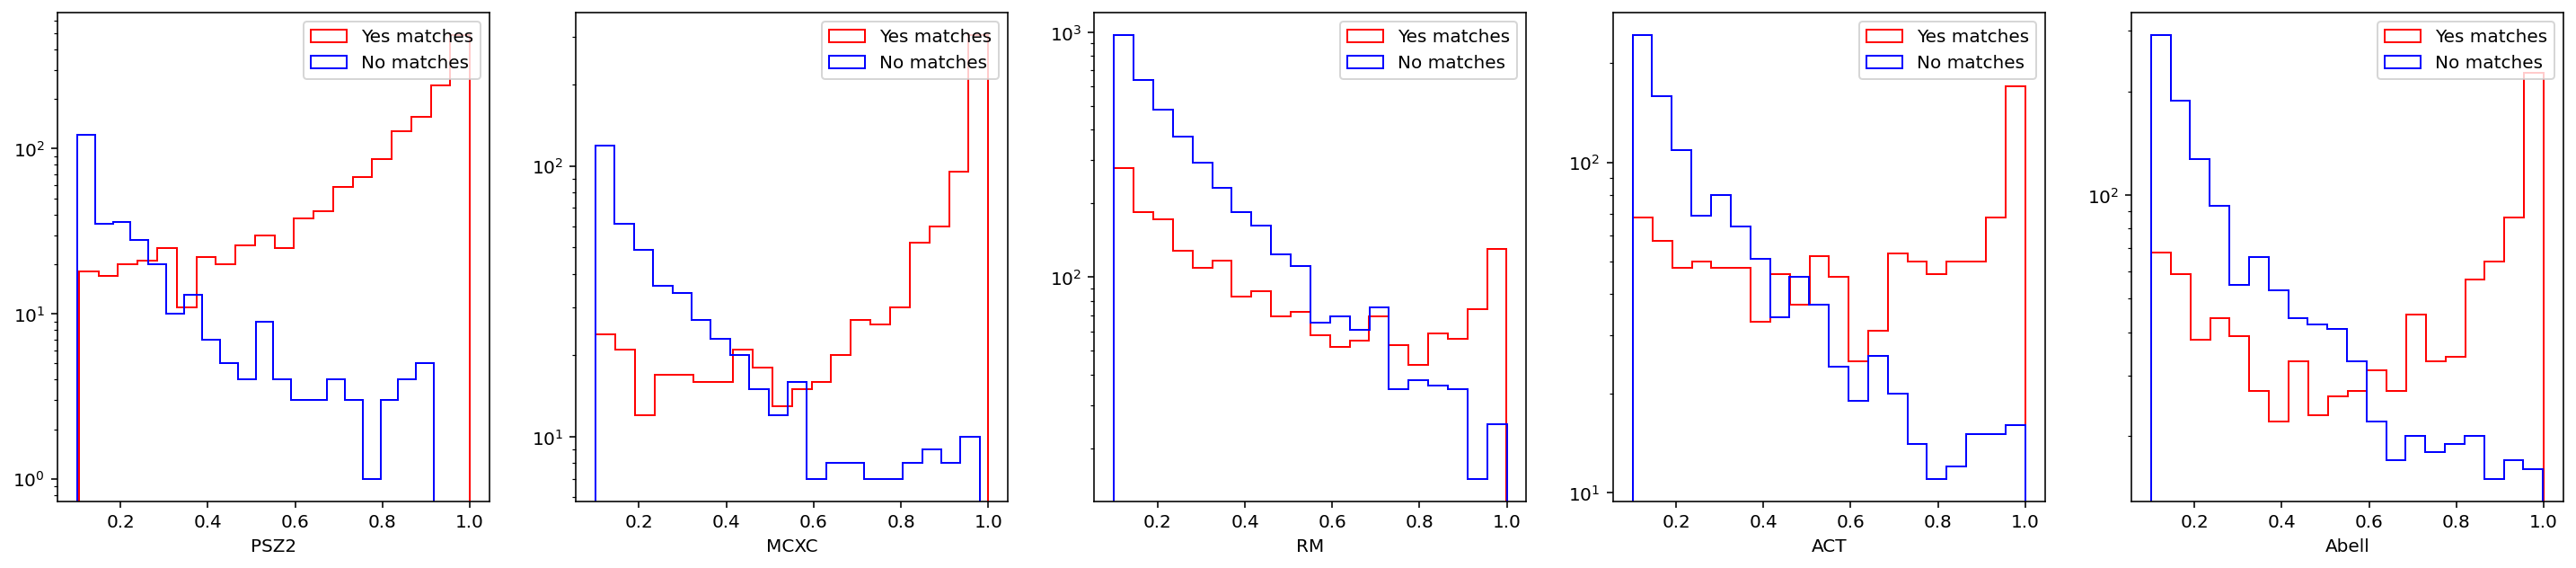

In [24]:
_, ax = plt.subplots(1, len(true_cats), figsize=(len(true_cats) * 5, 5))
for i, tr_cat in enumerate(true_cats):
    match_2circles(ax[i], pd.read_csv(det_cat), pd.read_csv(tr_cat))
    ax[i].set_xlabel(os.path.splitext(os.path.basename(tr_cat))[0])

1) Создаем координаты для детектированного каталога и для ground truth каталога <br>
2) Сопоставляем координаты: для каждого объекта из дет. каталога находим ближайшее скопление из gt-каталога <br>
3) В детектированном каталоге есть объекты, для которых в радиусе small_rad (400'') найдено скопление в gt-каталоге - это красная выборка<br>
4) Из gt-каталога исключаем те объекты, которые были сопоставлены с объектами из детектированного каталога в п.3<br>
5) Снова сопоставляем координаты детектированного каталога с новой версией gt-каталога: теперь мы выбираем те объекты, для которых ближйшее скопление находится в промежутке (small_rad, big_rad] ((400'', 1500'']) - это синяя выборка<br>

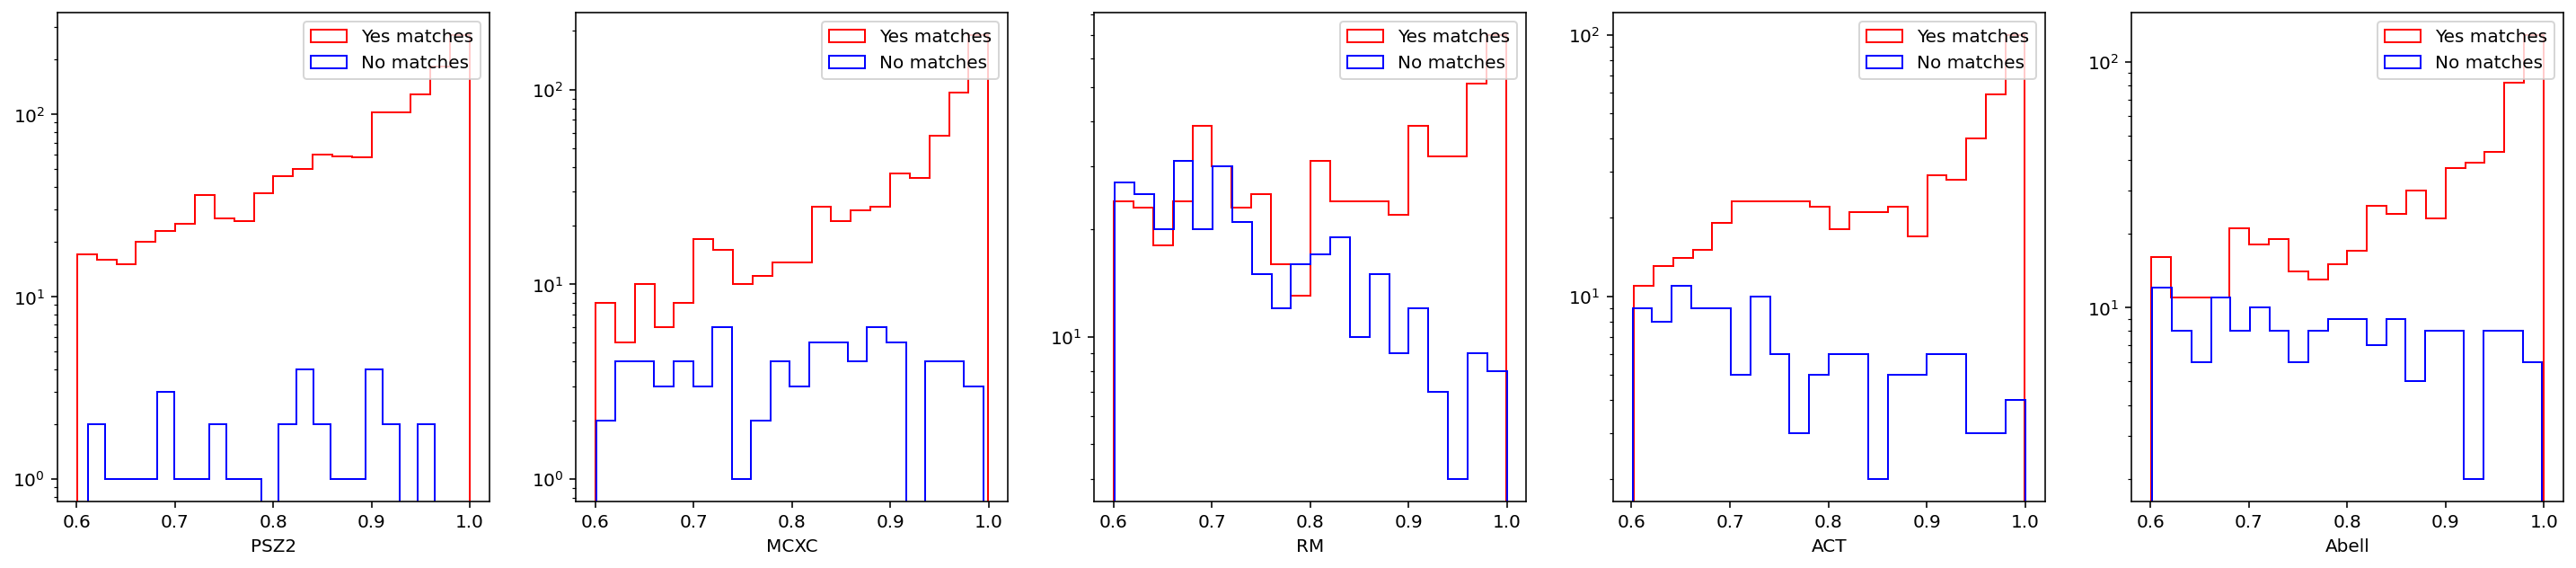

In [26]:
_, ax = plt.subplots(1, len(true_cats), figsize=(len(true_cats) * 5, 5))
for i, tr_cat in enumerate(true_cats):
    match_2circles(ax[i], pd.read_csv(det_cat), pd.read_csv(tr_cat), max_pred_lim=0.6)
    ax[i].set_xlabel(os.path.splitext(os.path.basename(tr_cat))[0])

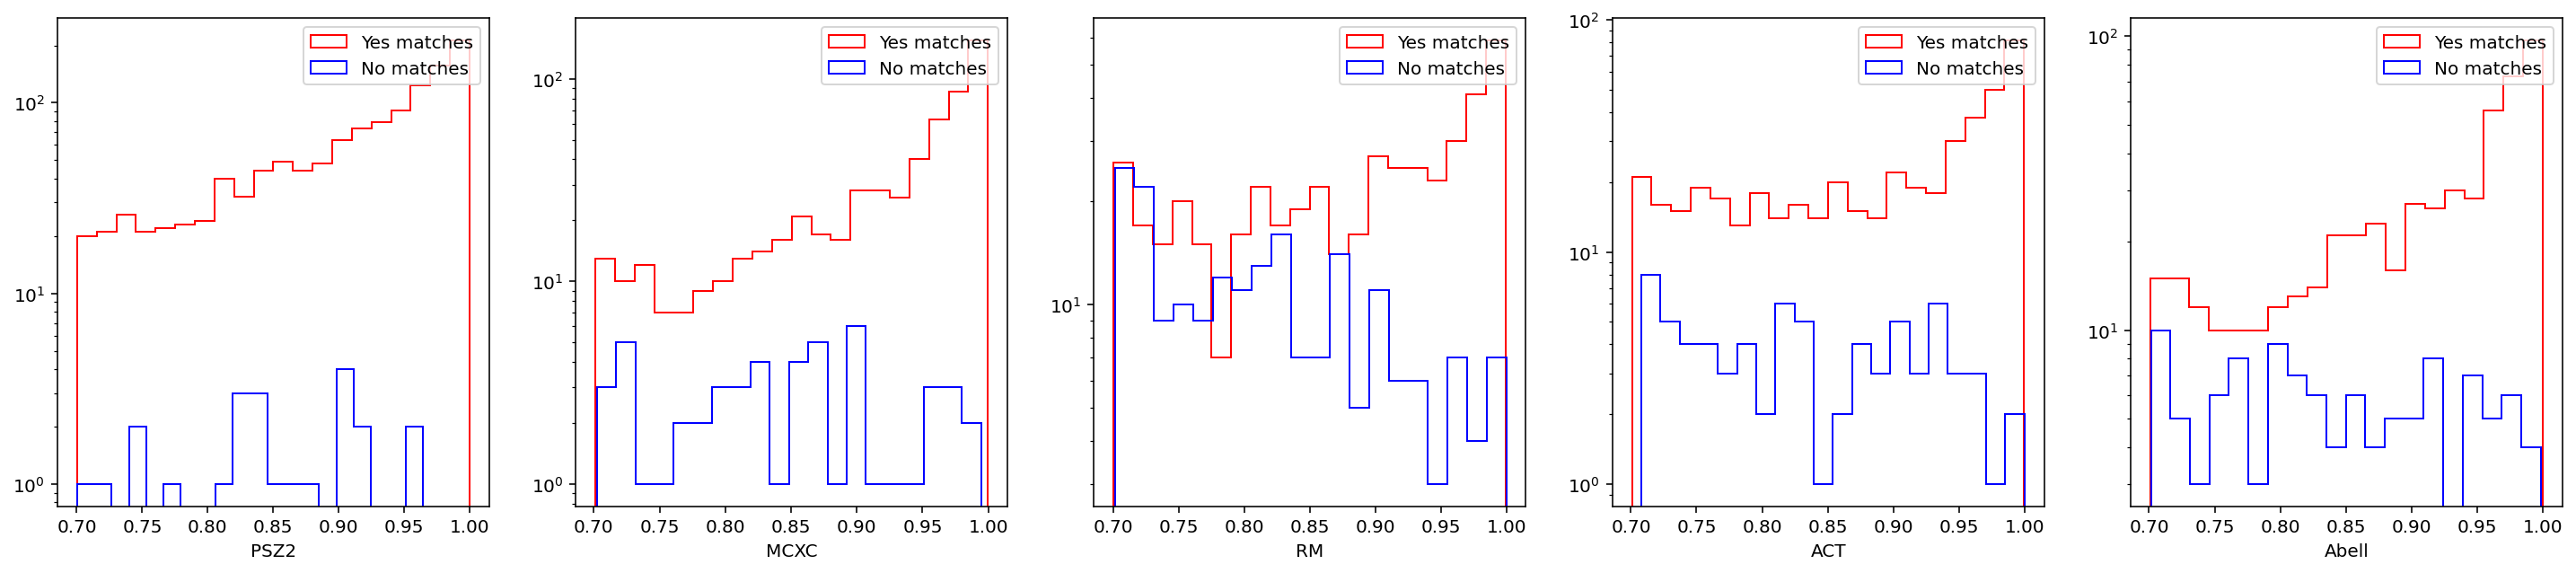

In [27]:
_, ax = plt.subplots(1, len(true_cats), figsize=(len(true_cats) * 5, 5))
for i, tr_cat in enumerate(true_cats):
    match_2circles(ax[i], pd.read_csv(det_cat), pd.read_csv(tr_cat), max_pred_lim=0.7)
    ax[i].set_xlabel(os.path.splitext(os.path.basename(tr_cat))[0])

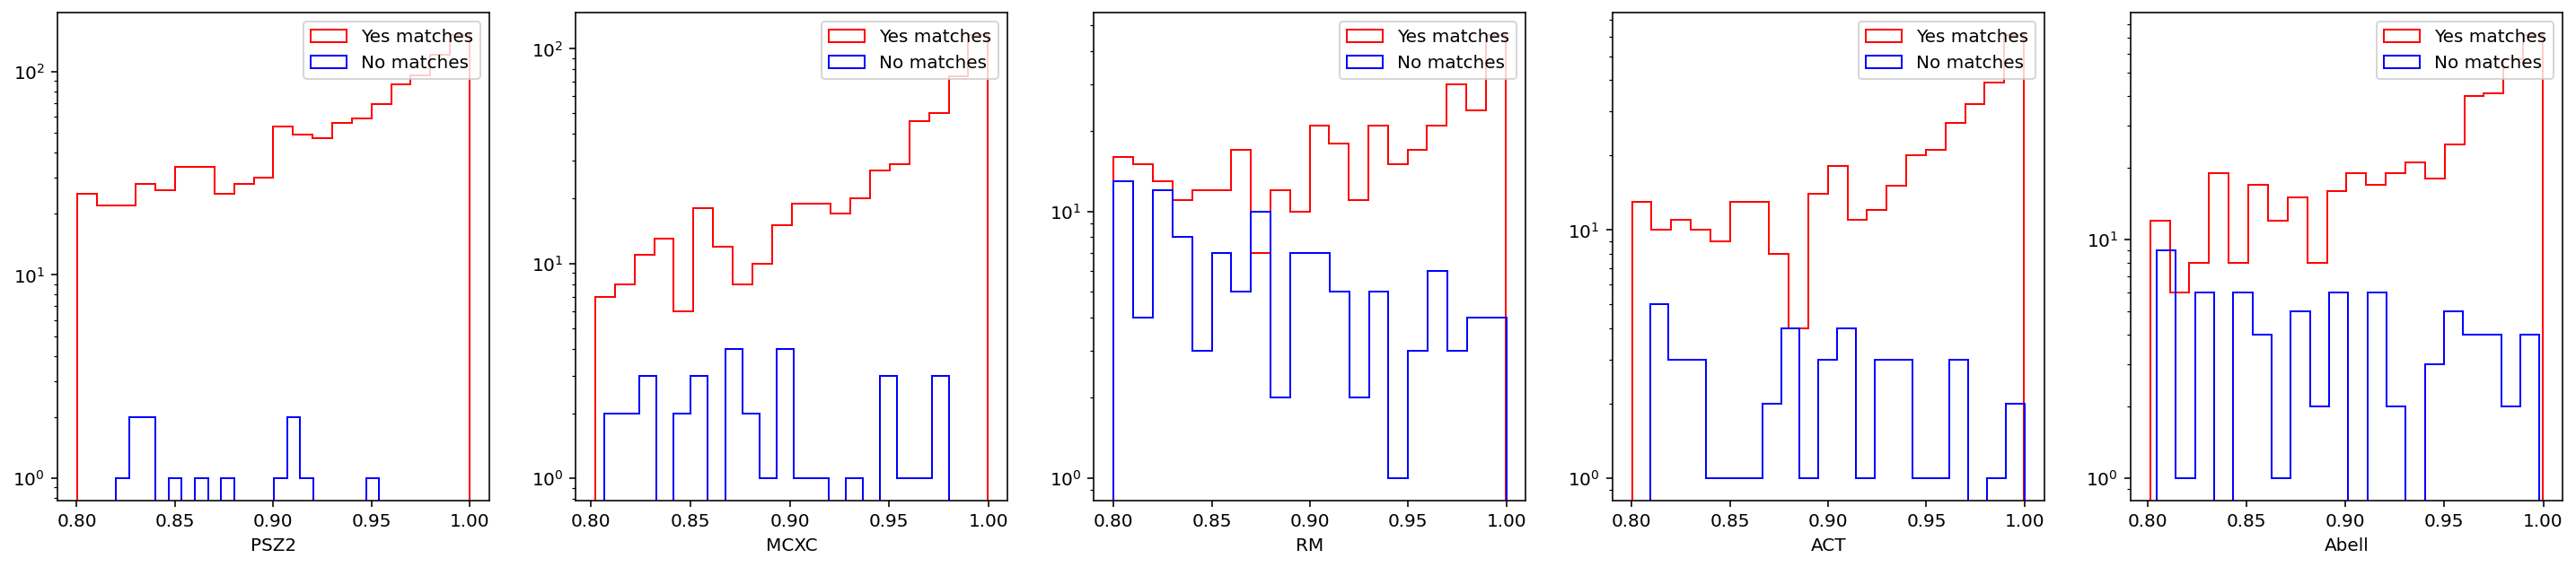

In [48]:
_, ax = plt.subplots(1, len(true_cats), figsize=(len(true_cats) * 5, 5))
for i, tr_cat in enumerate(true_cats):
    match_2circles(ax[i], pd.read_csv(det_cat), pd.read_csv(tr_cat), max_pred_lim=0.8)
    ax[i].set_xlabel(os.path.splitext(os.path.basename(tr_cat))[0])

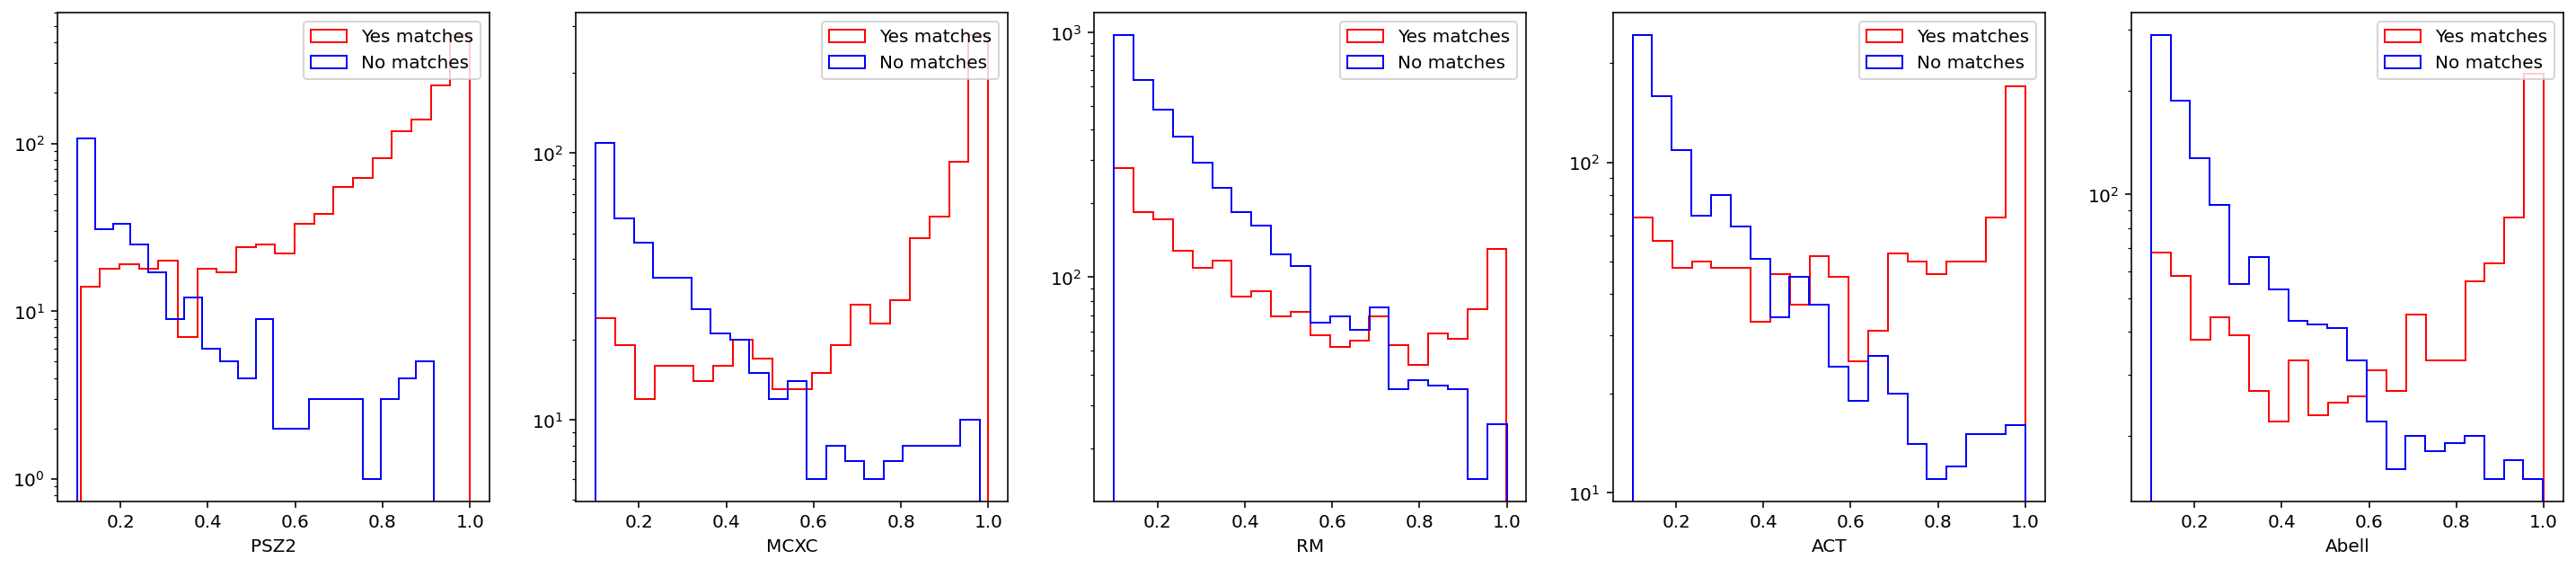

In [51]:
_, ax = plt.subplots(1, len(true_cats), figsize=(len(true_cats) * 5, 5))
for i, tr_cat in enumerate(true_cats):
    match_2circles(ax[i], pd.read_csv(det_cat), pd.read_csv(tr_cat), b_lim=15)
    ax[i].set_xlabel(os.path.splitext(os.path.basename(tr_cat))[0])
#b >= 15

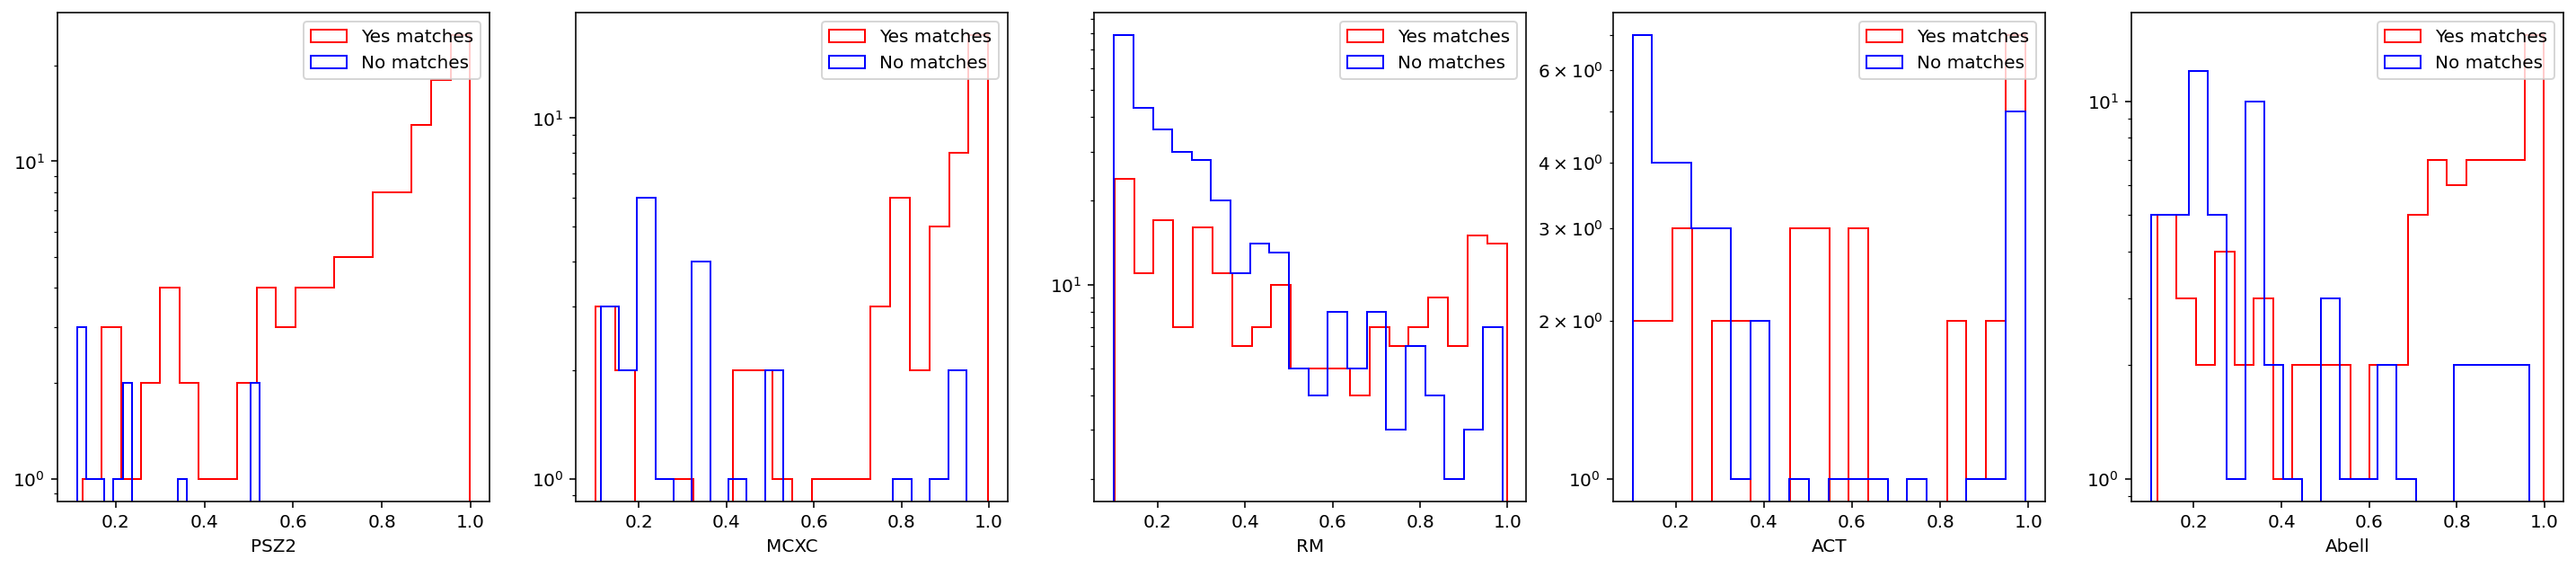

In [52]:
_, ax = plt.subplots(1, len(true_cats), figsize=(len(true_cats) * 5, 5))
for i, tr_cat in enumerate(true_cats):
    match_2circles(ax[i], pd.read_csv(det_cat), pd.read_csv(tr_cat), big_pix=east_val)
    ax[i].set_xlabel(os.path.splitext(os.path.basename(tr_cat))[0])
# east_val

In [13]:
def map_nside2(ax, big_pix, det_cat_file, true_cats_dir='/home/rt2122/Data/original_catalogs/csv/', s=50, special_cats=None, 
              add_legend=True):
    
    matr = one_pixel_fragmentation(2, big_pix, 10)
    mdict = matr2dict(matr)
    
    def cut_cat(cat):
        cat = cat[radec2pix(cat['RA'], cat['DEC'], 2) == big_pix]
        cat.index = np.arange(len(cat))
        cat['pix11'] = radec2pix(cat['RA'], cat['DEC'], 2**11)
        cat['x'] = -1
        cat['y'] = -1
        for i in cat.index:
            cat.loc[i, 'x'], cat.loc[i, 'y'] = mdict[cat.loc[i, 'pix11']]
        return cat
    
    #det_cat = cut_cat(pd.read_csv(det_cat_file))
    
    true_cats_files = next(os.walk(true_cats_dir))[-1]
    true_cats_files = [os.path.join(true_cats_dir, file) for file in true_cats_files]
    true_cats = {os.path.splitext(os.path.basename(file))[0] : cut_cat(pd.read_csv(file)) for file in true_cats_files}
    if special_cats is None:
        special_cats = list(true_cats)
    
    pic = np.ones_like(matr)
    pic[0, 0] = 0
    #_, ax = plt.subplots(1, 1, figsize=(15, 15))
    ax.imshow(pic, cmap='gray')
    #ss = ax.scatter(det_cat['x'], det_cat['y'], marker='x', c='r', s=s)
    #ss.set_label(os.path.splitext(os.path.basename(det_cat_file))[0])
    
    for name, marker, color in zip(true_cats, ['^', 's', 'o', 'v', '*'], ['c', 'r', 'g', 'c', 'g']):
        if (name in special_cats):
            continue
        ss = ax.scatter(true_cats[name]['x'], true_cats[name]['y'], marker=marker, alpha=0.6, s=s, c=color)
        ss.set_label(name)
    
    ax.set_xlabel(big_pix)
    if add_legend:
        ax.legend()

<ipython-input-13-0913268a876b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['pix11'] = radec2pix(cat['RA'], cat['DEC'], 2**11)
<ipython-input-13-0913268a876b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['x'] = -1
<ipython-input-13-0913268a876b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

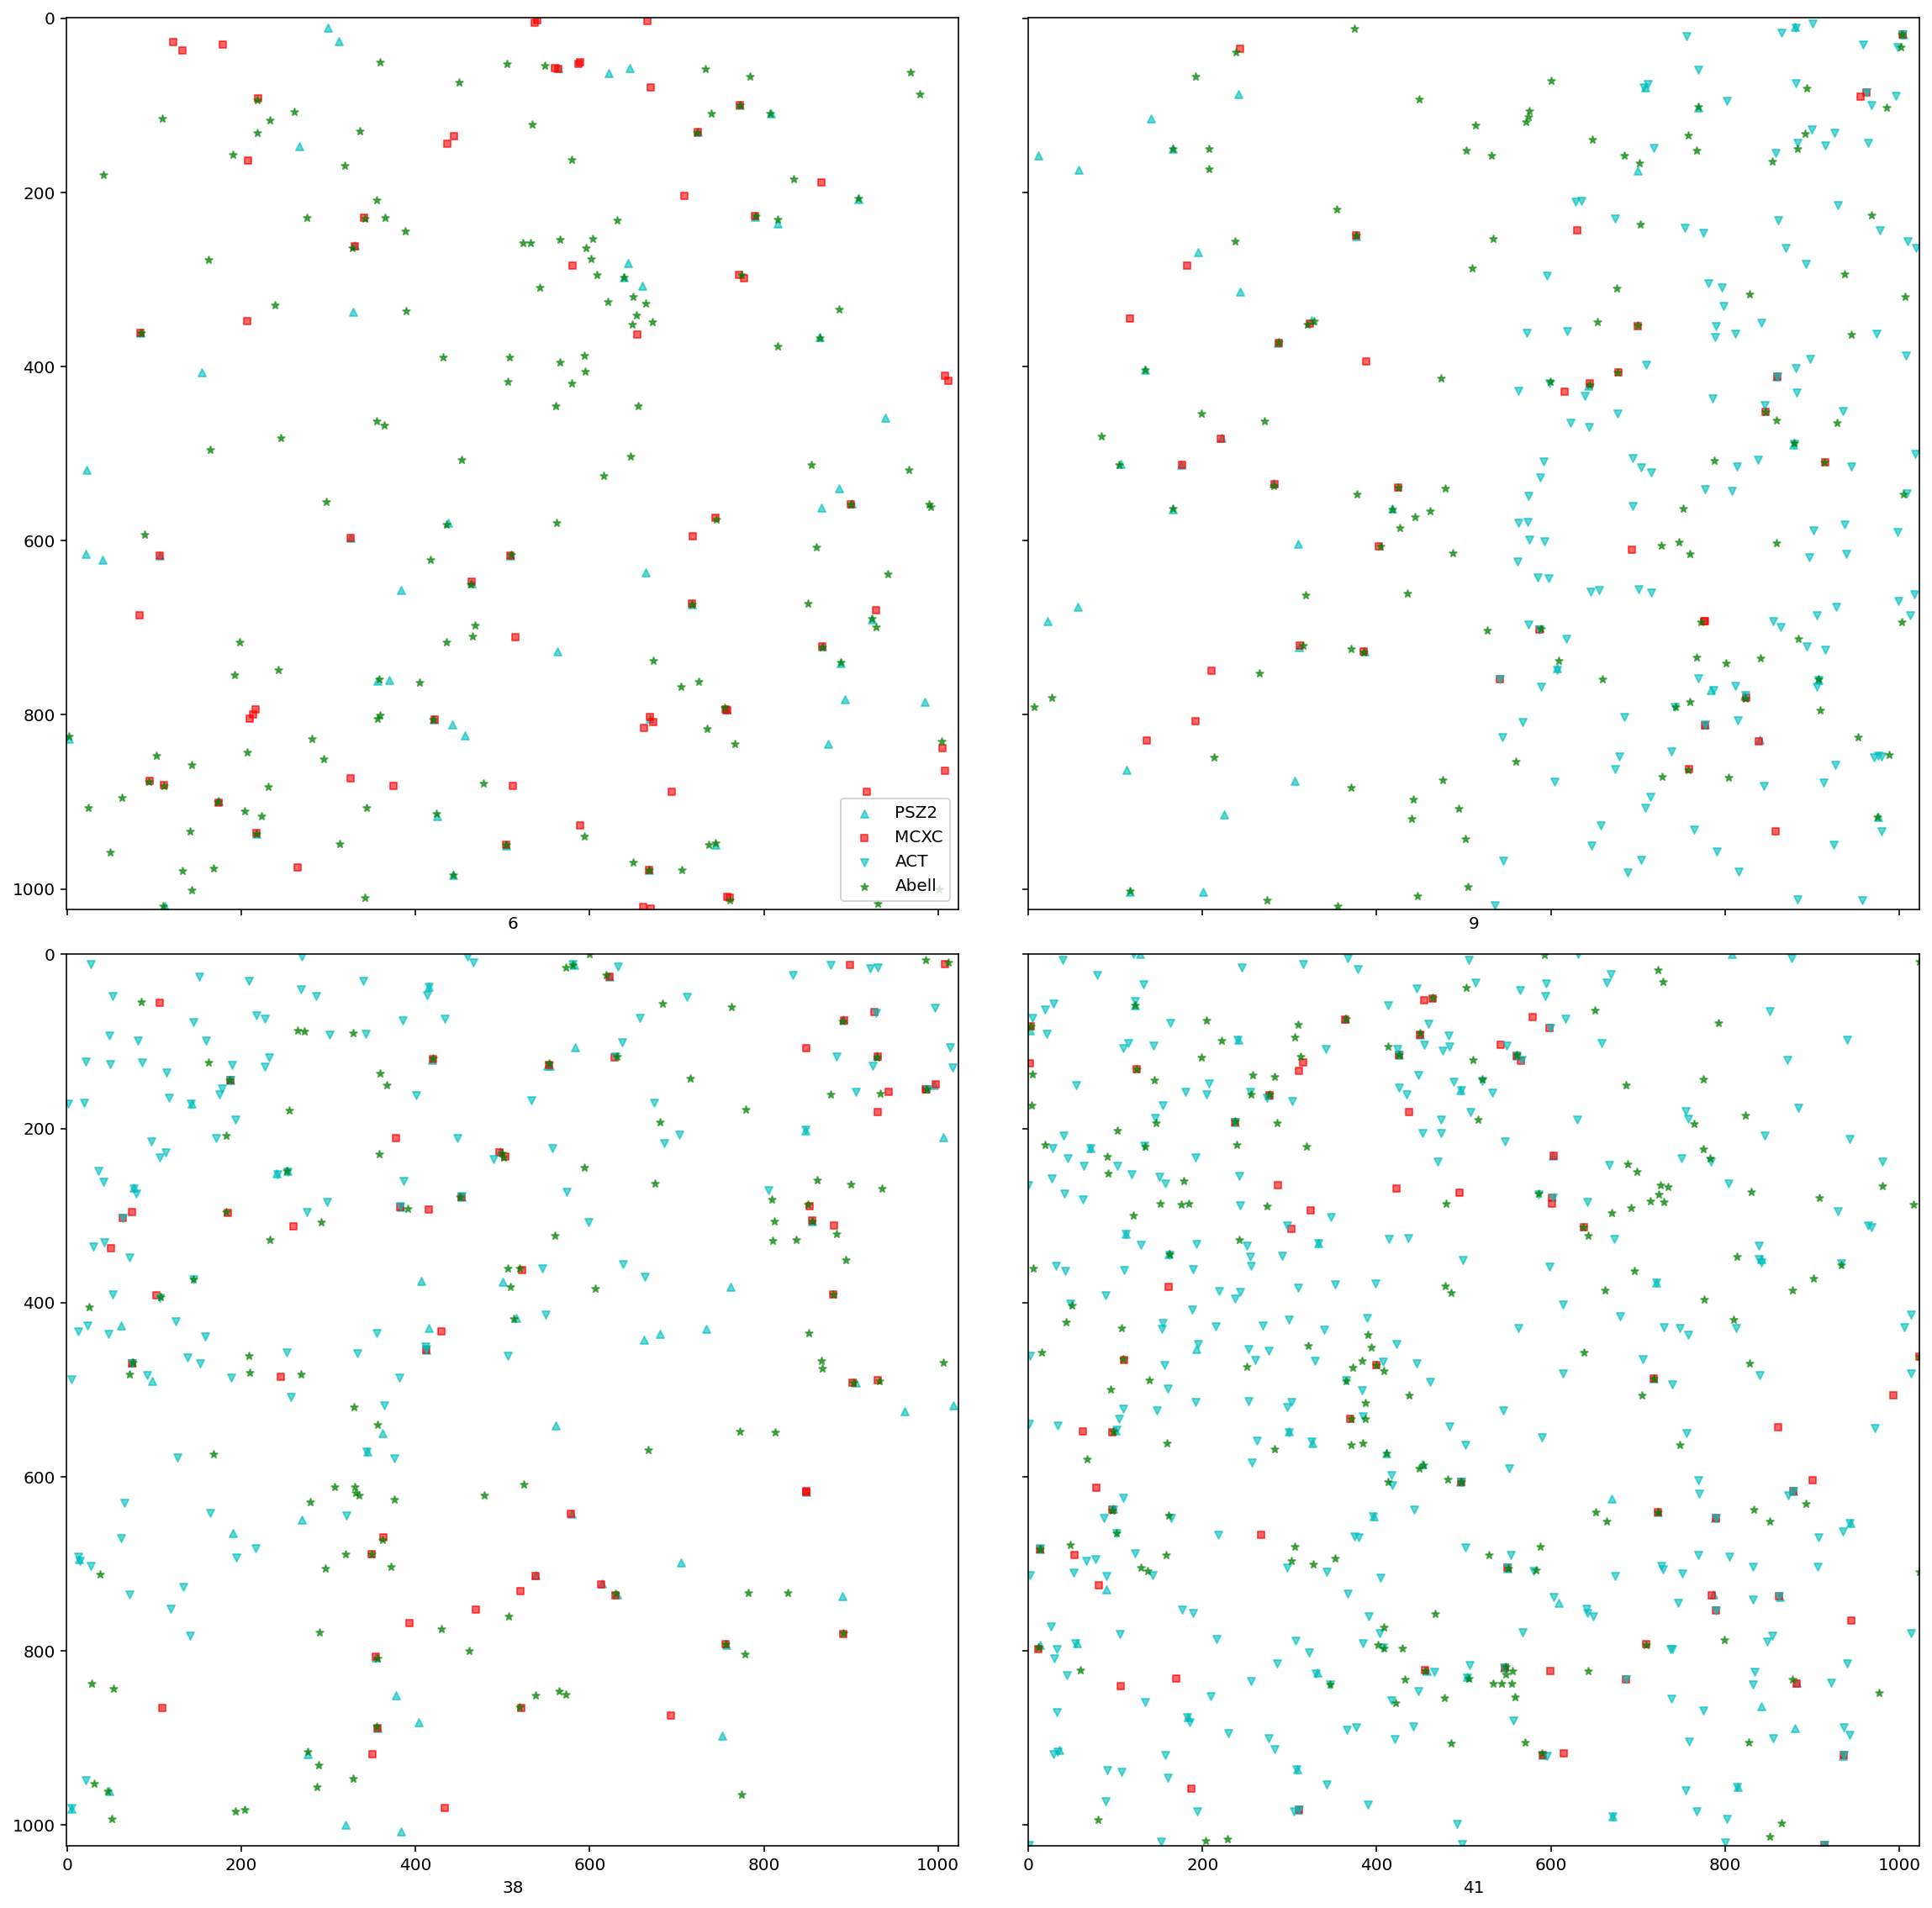

In [14]:
_, ax = plt.subplots(2, 2, figsize=(20, 20), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
det_cat = '/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv'
s=20
map_nside2(ax[0][0], 6, det_cat, s=s, special_cats=['RM'])
map_nside2(ax[0][1], 9, det_cat, add_legend=False, s=s, special_cats=['RM'])
map_nside2(ax[1][0], 38, det_cat, add_legend=False, s=s, special_cats=['RM'])
map_nside2(ax[1][1], 41, det_cat, add_legend=False, s=s, special_cats=['RM'])

<ipython-input-111-70d3d691d6d4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['pix11'] = radec2pix(cat['RA'], cat['DEC'], 2**11)
<ipython-input-111-70d3d691d6d4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['x'] = -1
<ipython-input-111-70d3d691d6d4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

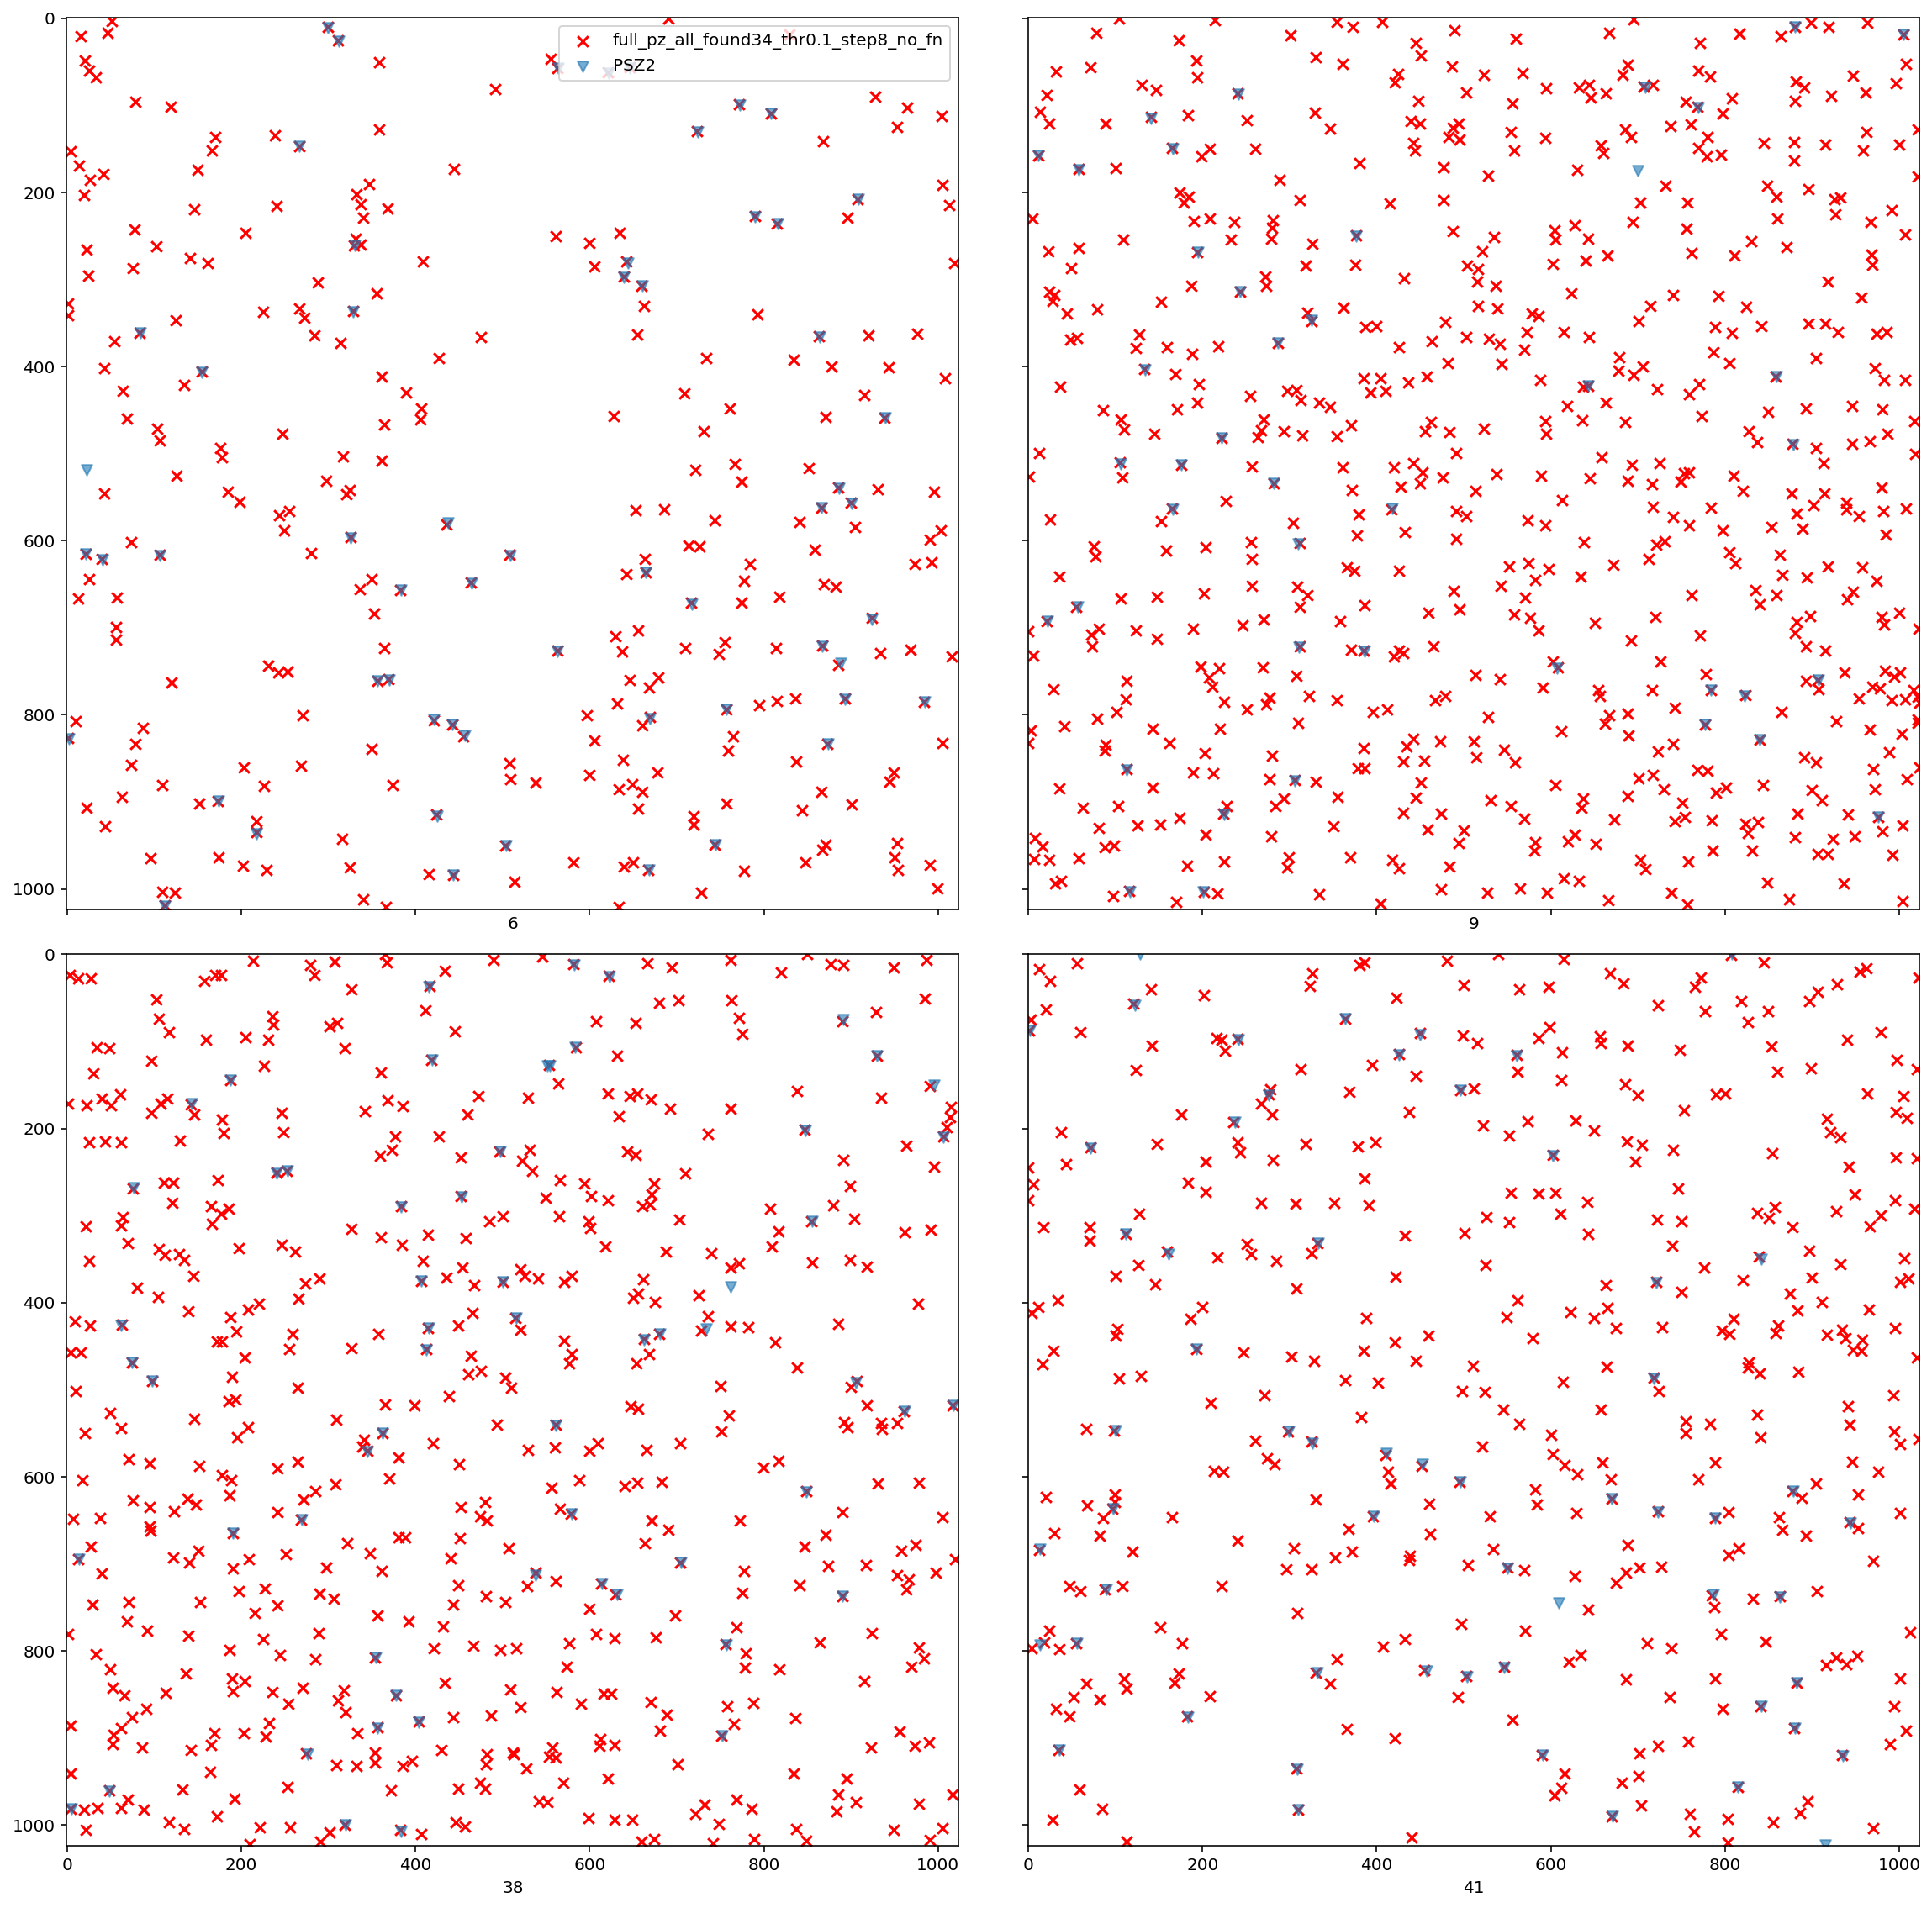

In [116]:
_, ax = plt.subplots(2, 2, figsize=(20, 20), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
det_cat = '/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv'
s=40
spec = ['PSZ2']
map_nside2(ax[0][0], 6, det_cat, s=s, special_cats=spec)
map_nside2(ax[0][1], 9, det_cat, add_legend=False, s=s, special_cats=spec)
map_nside2(ax[1][0], 38, det_cat, add_legend=False, s=s, special_cats=spec)
map_nside2(ax[1][1], 41, det_cat, add_legend=False, s=s, special_cats=spec)

<ipython-input-111-70d3d691d6d4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['pix11'] = radec2pix(cat['RA'], cat['DEC'], 2**11)
<ipython-input-111-70d3d691d6d4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['x'] = -1
<ipython-input-111-70d3d691d6d4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

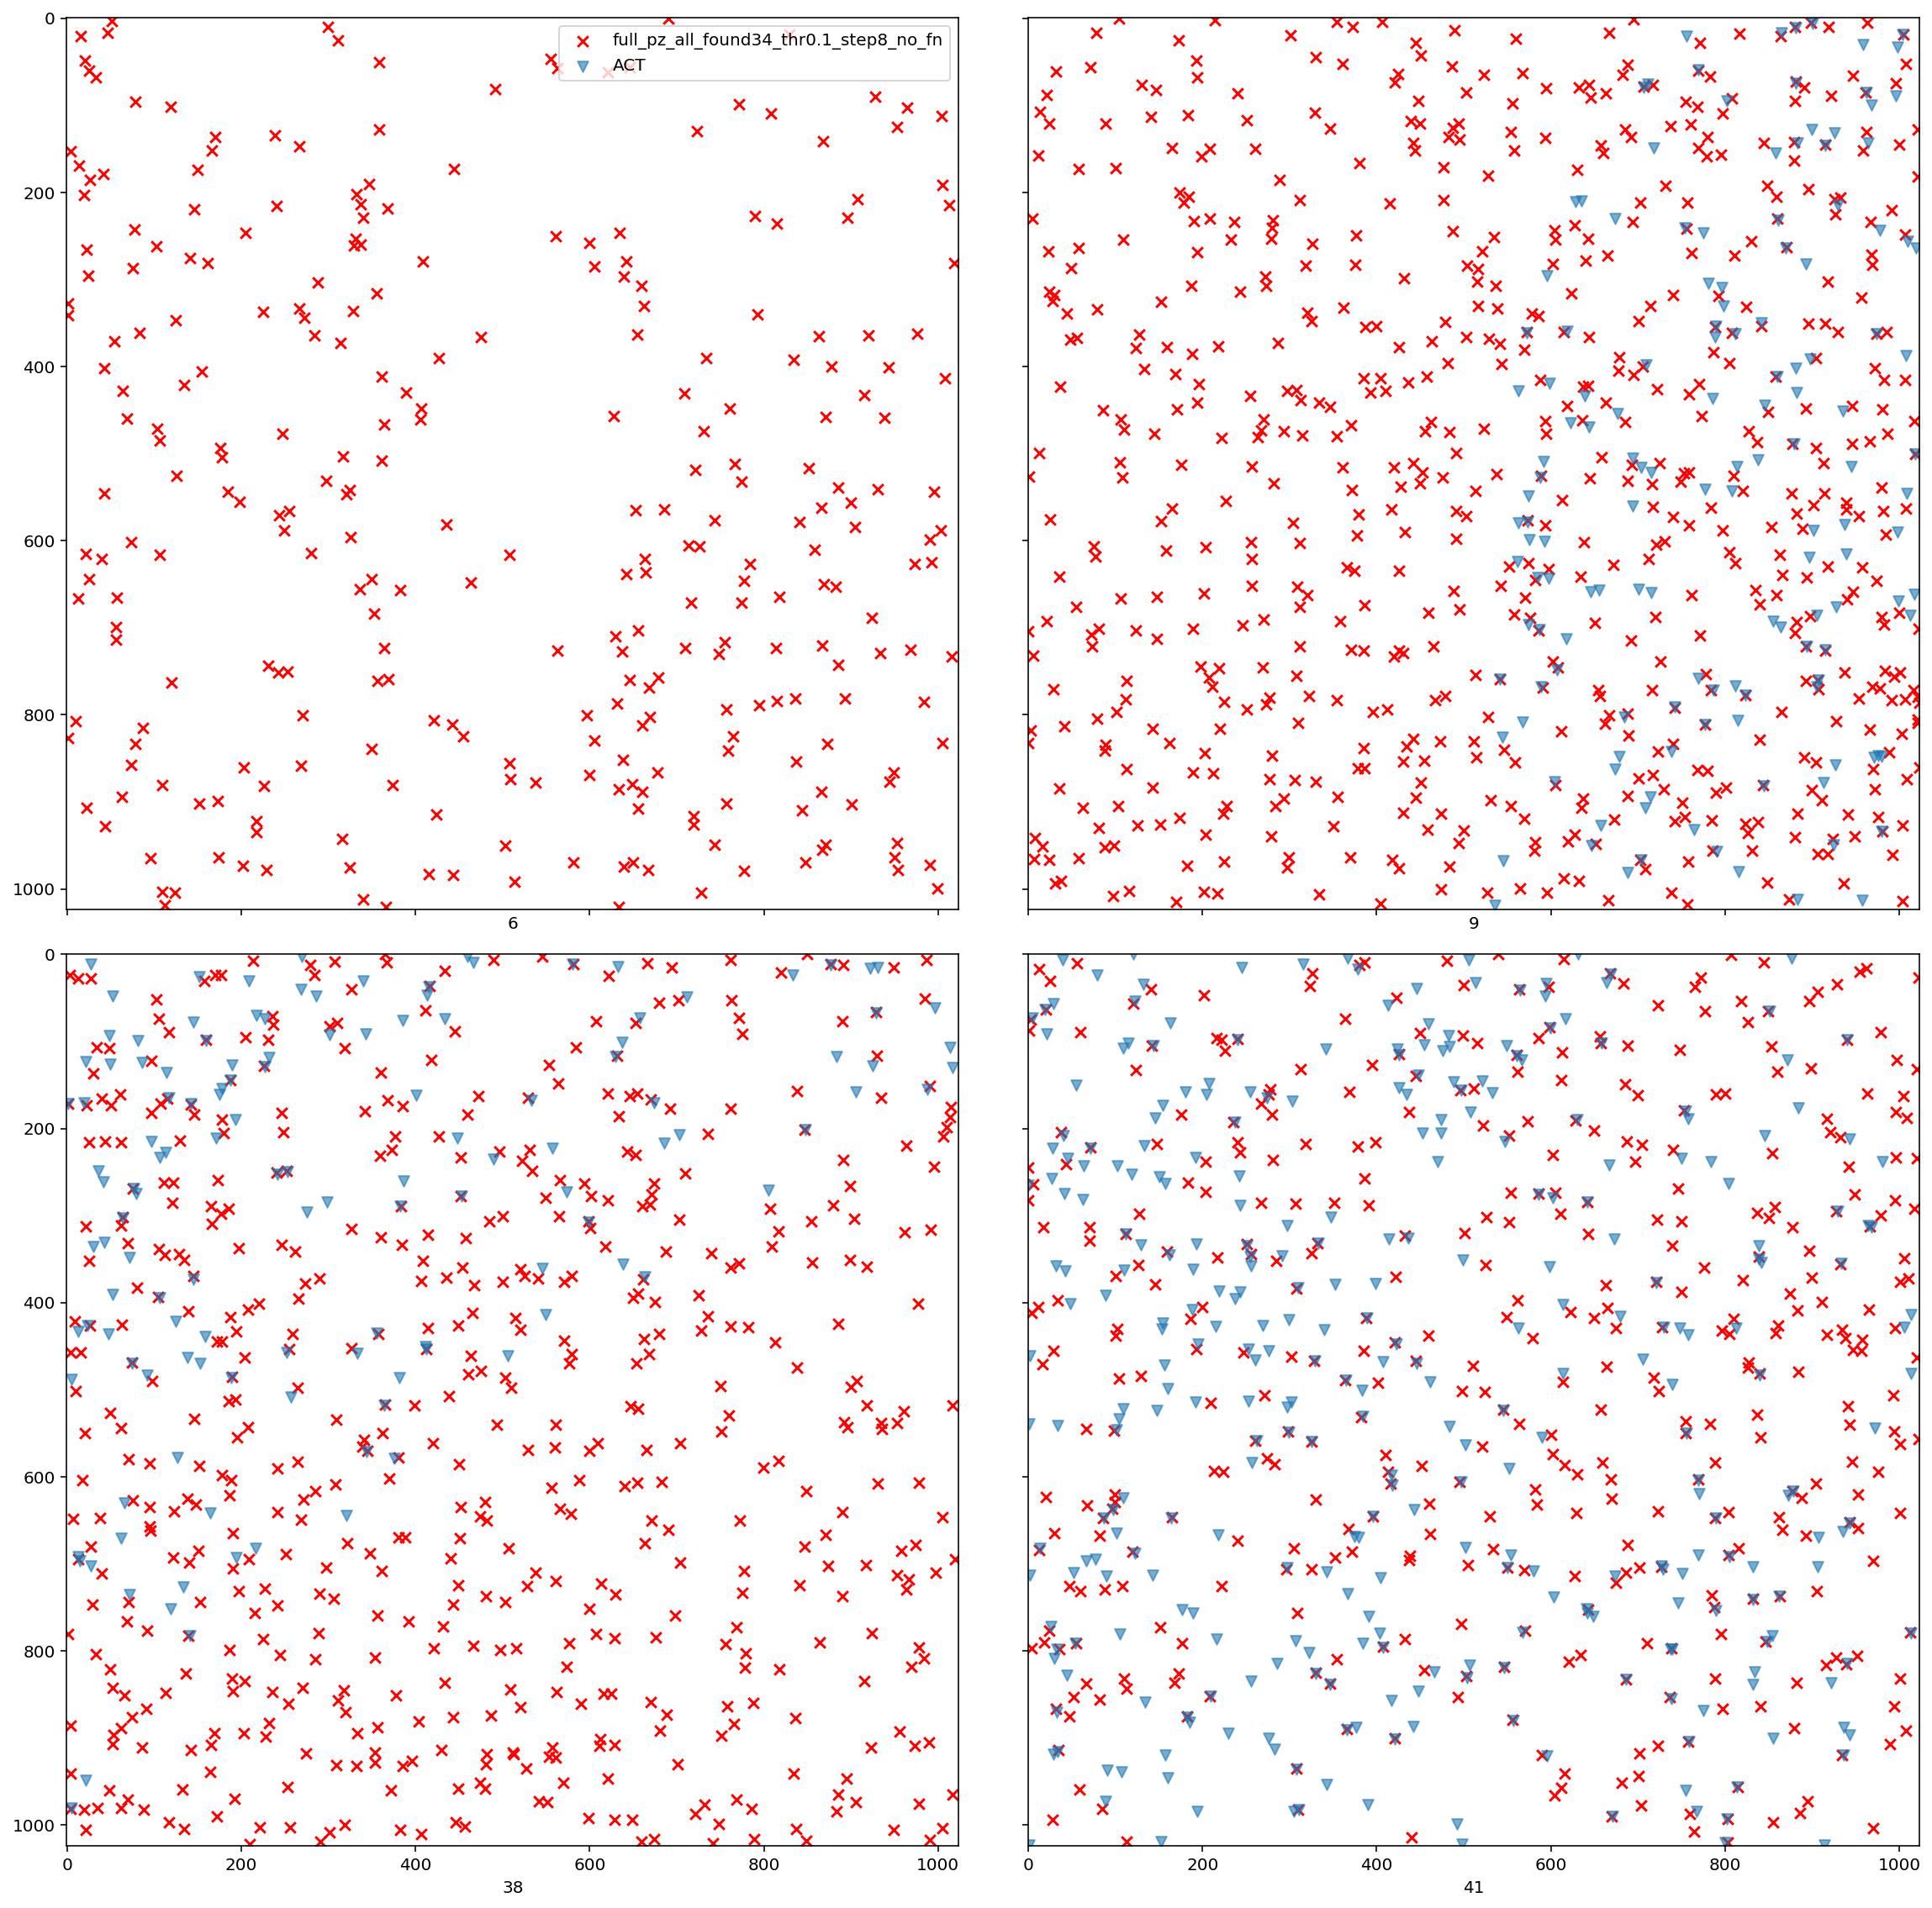

In [115]:
_, ax = plt.subplots(2, 2, figsize=(20, 20), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
det_cat = '/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv'
s=40
spec = ['ACT']
map_nside2(ax[0][0], 6, det_cat, s=s, special_cats=spec)
map_nside2(ax[0][1], 9, det_cat, add_legend=False, s=s, special_cats=spec)
map_nside2(ax[1][0], 38, det_cat, add_legend=False, s=s, special_cats=spec)
map_nside2(ax[1][1], 41, det_cat, add_legend=False, s=s, special_cats=spec)

In [2]:
det_cats = { 
        'pz_all_found34' : '/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8.csv',
        'br_cat' : '/home/rt2122/Data/SRGz/brcat.csv'
        }

In [3]:
recall_df = stat_orig_cats(det_cats, '/home/rt2122/Data/original_catalogs/csv', 
                                    big_pix=list(range(48)), dict_cut={}, recall_only=True, format_s=lambda x:'{:.2f}'.format(x))
print(recall_df.to_latex())

/home/rt2122/L/git/data-segmentation-2/modules/DS_models_stat.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['found'] = False
/home/rt2122/L/git/data-segmentation-2/modules/DS_models_stat.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['b'] = sc.galactic.b.degree
/home/rt2122/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

\begin{tabular}{llllllrr}
\toprule
{} &  PSZ2 &  MCXC &    RM &   ACT & Abell &     fp &    all \\
\midrule
pz\_all\_found34 &  0.92 &  0.44 &  0.06 &  0.24 &  0.21 &  19849 &  23352 \\
br\_cat         &  0.74 &  0.38 &  0.04 &  0.19 &  0.18 &  11223 &  13772 \\
\bottomrule
\end{tabular}



In [5]:
recall_df = stat_orig_cats(det_cats, '/home/rt2122/Data/original_catalogs/csv', 
                                    big_pix=list(range(48)), dict_cut={}, recall_only=True, max_pred_lim=0.8, 
                           format_s=lambda x:'{:.2f}'.format(x))
print(recall_df.to_latex())

\begin{tabular}{llllllrr}
\toprule
{} &  PSZ2 &  MCXC &    RM &   ACT & Abell &     fp &    all \\
\midrule
pz\_all\_found34 &  0.64 &  0.29 &  0.01 &  0.09 &  0.10 &    316 &   1513 \\
br\_cat         &  0.74 &  0.38 &  0.04 &  0.19 &  0.18 &  11223 &  13772 \\
\bottomrule
\end{tabular}



In [4]:
def n_found_in_cats(gt_df, det_df, rad):
    ans = 0
    det_sc = SkyCoord(ra=np.array(det_df['RA']) *u.degree, dec=np.array(det_df['DEC'])*u.degree, frame='icrs')
    for i in range(len(gt_df)):
        ra, dec = gt_df.loc[i, ['RA', 'DEC']]
        sc_gt = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
        
        angle = sc_gt.separation(det_sc)
        ans += np.count_nonzero(angle.degree <= rad)
    return ans

In [5]:
def n_src2rad(ax, det_cat_file, true_cat_dir='/home/rt2122/Data/original_catalogs/csv/', rads=[0, 1600/3600, 100/3600], vline=400/3600, 
             cat='PSZ2'):
    n_src = []
    res_src = []
    
    tr_df = pd.read_csv(os.path.join(true_cat_dir, cat + '.csv'))
    #tr_sc = SkyCoord(ra=np.array(tr_df['RA'])*u.degree, dec=np.array(tr_df['DEC'])*u.degree, frame='icrs')
    det_df = pd.read_csv(det_cat_file)
    #det_sc = SkyCoord(ra=np.array(det_df['RA'])*u.degree, dec=np.array(det_df['DEC'])*u.degree, frame='icrs')
    #_, d2d, _ = tr_sc.match_to_catalog_sky(det_sc)
    
    
    for rad in np.arange(*rads):
        #n_src.append(np.count_nonzero(d2d.degree <= rad))
        n_src.append(n_found_in_cats(tr_df, det_df, rad))
        if len(n_src) > 1:
            res_src.append(n_src[-1] - n_src[-2])
        else:
            res_src.append(n_src[-1])
        
    x = np.arange(*rads)
    x += rads[-1]/2
    x *= 3600
    ax.plot(x, res_src/np.arange(*rads))
    ax.set_xlabel('radius, \'\'  ' + cat)
    ax.set_ylabel('n_src / radius')
    ax.grid()
    for v, c in zip(vline, 'rcc'):
        line = ax.axvline(3600 * v, c=c)
        line.set_label(str(int(v * 3600)) + ' \'\'')
    ax.legend()

<ipython-input-5-fe69bdfee2a5>:24: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(x, res_src/np.arange(*rads))
<ipython-input-5-fe69bdfee2a5>:24: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(x, res_src/np.arange(*rads))
<ipython-input-5-fe69bdfee2a5>:24: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(x, res_src/np.arange(*rads))
<ipython-input-5-fe69bdfee2a5>:24: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(x, res_src/np.arange(*rads))


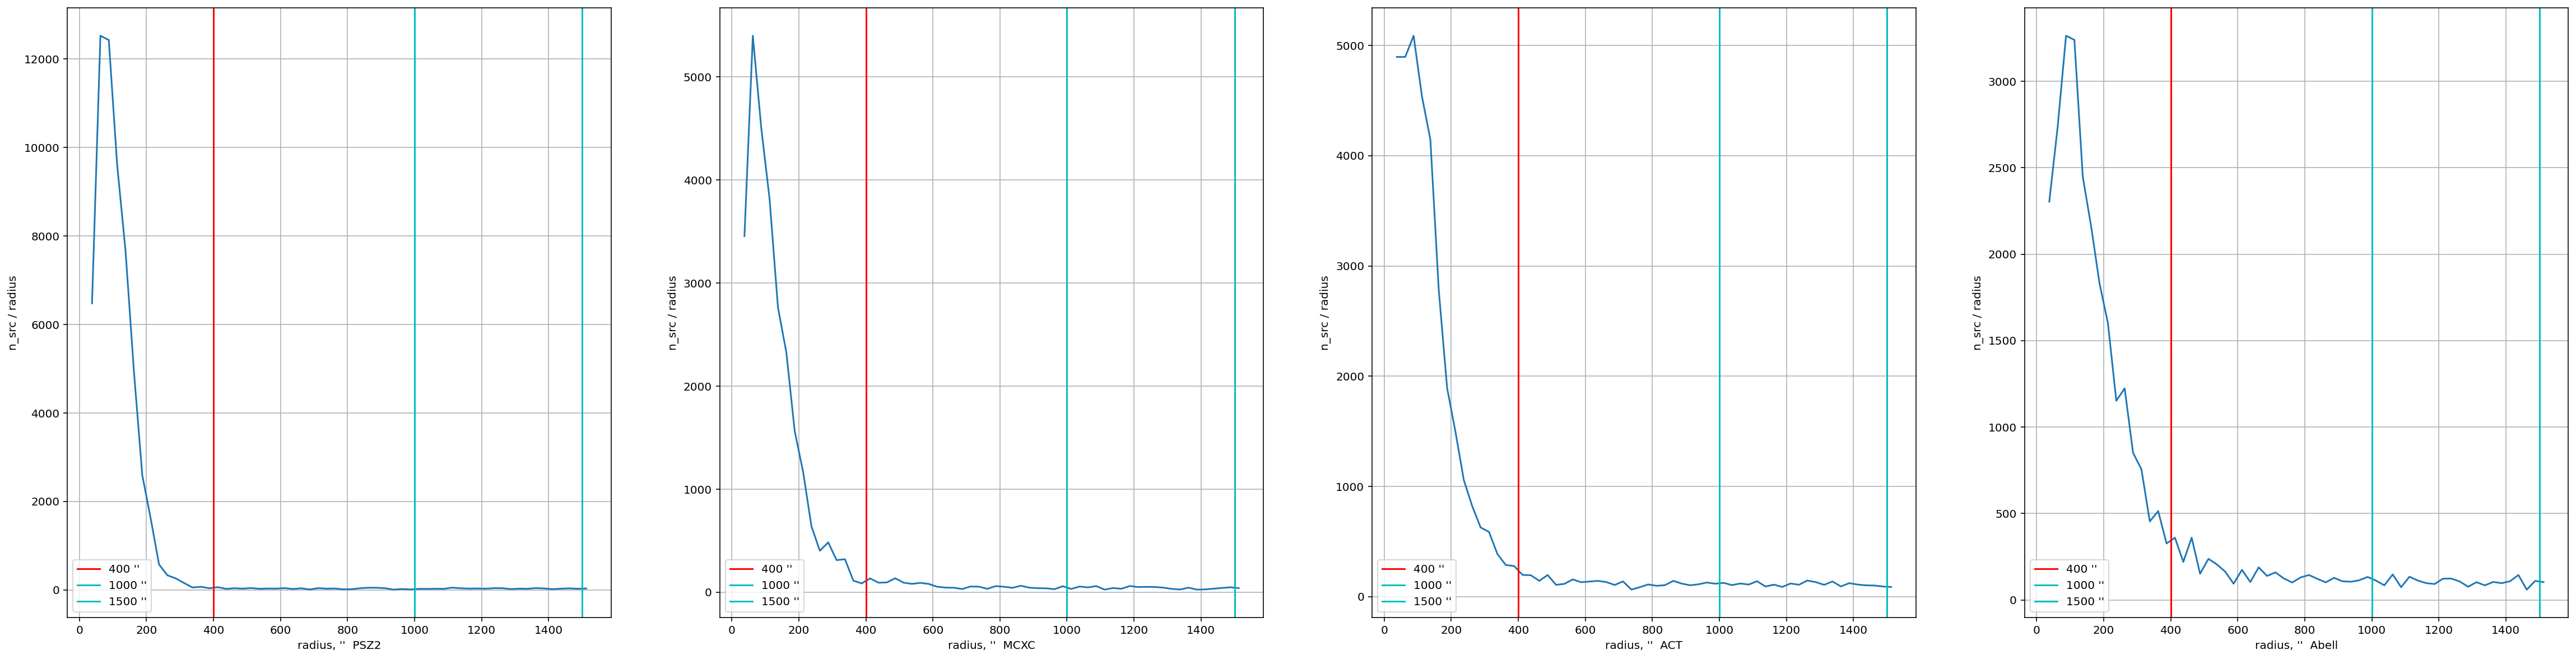

In [6]:
_, ax = plt.subplots(1, 4, figsize=(4 * 10, 10))
for i, cat in tqdm(enumerate(['PSZ2', 'MCXC', 'ACT', 'Abell'])):
    n_src2rad(ax[i], '/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv', cat=cat, 
          rads=[0, 1500/3600, 25/3600], vline=[400/3600, 1000/3600, 1500/3600])

In [4]:
df = rematch_cat('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv', 
                 clusters_dir='/home/rt2122/Data/original_catalogs/csv/opt/')

/home/rt2122/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
df = df[df['status'] != 'fp']
df = df[df['z'] != -1]
df.index = np.arange(len(df))

In [8]:
df

,RA,DEC,area,min_rad,max_rad,mean_rad,min_pred,max_pred,tRA,tDEC,status,catalog,M500,z,pix2,LAMBDA
0,258.585084,29.154516,37.0,1.899252,4.821417,3.509465,0.100698,0.644942,258.652932,29.150932,tp,RM,NaN,0.420500,train_pix,32.543076
1,259.267856,25.814784,32.0,2.152288,5.248476,3.271458,0.100586,0.650705,259.202307,25.779575,tp,RM,NaN,0.339626,train_pix,46.120003
2,257.002616,26.489642,10.0,1.013145,2.945952,1.959494,0.111807,0.216614,257.082221,26.450263,tp,RM,NaN,0.381536,train_pix,21.956121
3,255.371406,23.807457,26.0,1.977635,3.966621,3.002428,0.106522,0.501476,255.377347,23.795366,tp,RM,NaN,0.170019,train_pix,26.395319
4,250.661090,27.395382,2.0,1.102422,1.772969,1.336654,0.104162,0.120304,250.661019,27.443704,tp,RM,NaN,0.102795,train_pix,50.788025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15689,147.165077,38.020659,NaN,NaN,NaN,NaN,NaN,NaN,147.165077,38.020659,fn,RM,NaN,0.472841,NaN,33.382095
15690,224.299738,30.163340,NaN,NaN,NaN,NaN,NaN,NaN,224.299738,30.163340,fn,RM,NaN,0.415880,NaN,25.678335
15691,254.675664,40.883820,NaN,NaN,NaN,NaN,NaN,NaN,254.675664,40.883820,fn,RM,NaN,0.394215,NaN,28.805605
15692,20.045703,5.469387,NaN,NaN,NaN,NaN,NaN,NaN,20.045703,5.469387,fn,RM,NaN,0.450931,NaN,27.188578


In [27]:
q_z = [df['z'].quantile(i/6) for i in range(0, 7)]
q_z[0] = 0
q_z[-1] = 2
print(repr(q_z))

[0, 0.23365732499999997, 0.30489957, 0.35226274999999996, 0.39521536, 0.4467386, 2]


In [28]:
q_lambda = {}
for i in range(len(q_z) - 1):
    st = q_z[i]
    en = q_z[i + 1]
    matched = np.logical_and(st <= df['z'], df['z'] < en)
    cur_df = df[matched]
    q_lambda[en] = [cur_df['LAMBDA'].quantile(i / 10) for i in range(11)]
    q_lambda[en][-1] = 100

In [29]:
q_lambda= pd.DataFrame(q_lambda)
q_lambda

,0.233657,0.304900,0.352263,0.395215,0.446739,2.000000
0,19.988230,19.881445,19.911955,19.942465,19.927210,22.825655
1,21.338295,21.132353,21.422197,22.154436,26.036828,33.725335
2,22.596830,22.551065,22.718870,23.890452,28.271680,37.317880
3,24.061308,24.030798,24.091818,25.470868,30.262455,40.757877
4,25.769865,25.846140,25.739355,27.493677,32.634605,44.106346
5,27.913188,27.905561,27.814032,29.873453,35.288970,47.569220
6,31.017576,30.871128,30.758242,32.710876,38.797615,51.337204
7,34.701652,34.575038,34.160103,36.308000,43.252068,56.432365
8,39.850204,39.834953,39.865463,41.696060,49.842216,62.869965
9,50.063412,51.352455,50.612590,51.413477,61.245308,76.202810


In [30]:
recalls = []
for j in range(len(q_lambda[q_z[1]]) - 1):
    line = {}
    for i in range(len(q_z) - 1):
        z_st = q_z[i]
        z_en = q_z[i + 1]
        m_st = q_lambda[z_en][j]
        m_en = q_lambda[z_en][j + 1]
        
        matched1 = np.logical_and(z_st <= df['z'], df['z'] < z_en)
        matched2 = np.logical_and(m_st <= df['LAMBDA'], df['LAMBDA'] < m_en)
        cur_df = df[np.logical_and(matched1, matched2)]
        recall = np.count_nonzero(cur_df['status'] == 'tp') / len(cur_df)
        line['({:.2f},{:.2f})'.format(z_st, z_en)] = recall
    recalls.append(pd.DataFrame(line, index=[j]))
recalls = pd.concat(recalls)

In [31]:
cm = sns.light_palette("green", as_cmap=True)

s = recalls.style.background_gradient(cmap=cm)
s

,"(0.00,0.23)","(0.23,0.30)","(0.30,0.35)","(0.35,0.40)","(0.40,0.45)","(0.45,2.00)"
0,0.019084,0.042636,0.019380,0.026820,0.030534,0.022901
1,0.034884,0.018939,0.007605,0.038168,0.030651,0.019231
2,0.022727,0.026316,0.022814,0.015267,0.022901,0.034221
3,0.061303,0.015564,0.015504,0.023077,0.026820,0.022989
4,0.083650,0.034351,0.026515,0.011494,0.034615,0.007663
5,0.084291,0.034351,0.041825,0.030651,0.034351,0.053640
6,0.083969,0.030651,0.034483,0.019011,0.034351,0.057252
7,0.134100,0.068966,0.042146,0.034483,0.027132,0.038168
8,0.152672,0.122605,0.060837,0.030534,0.045113,0.083969
9,0.457831,0.292683,0.244898,0.152263,0.146667,0.129032


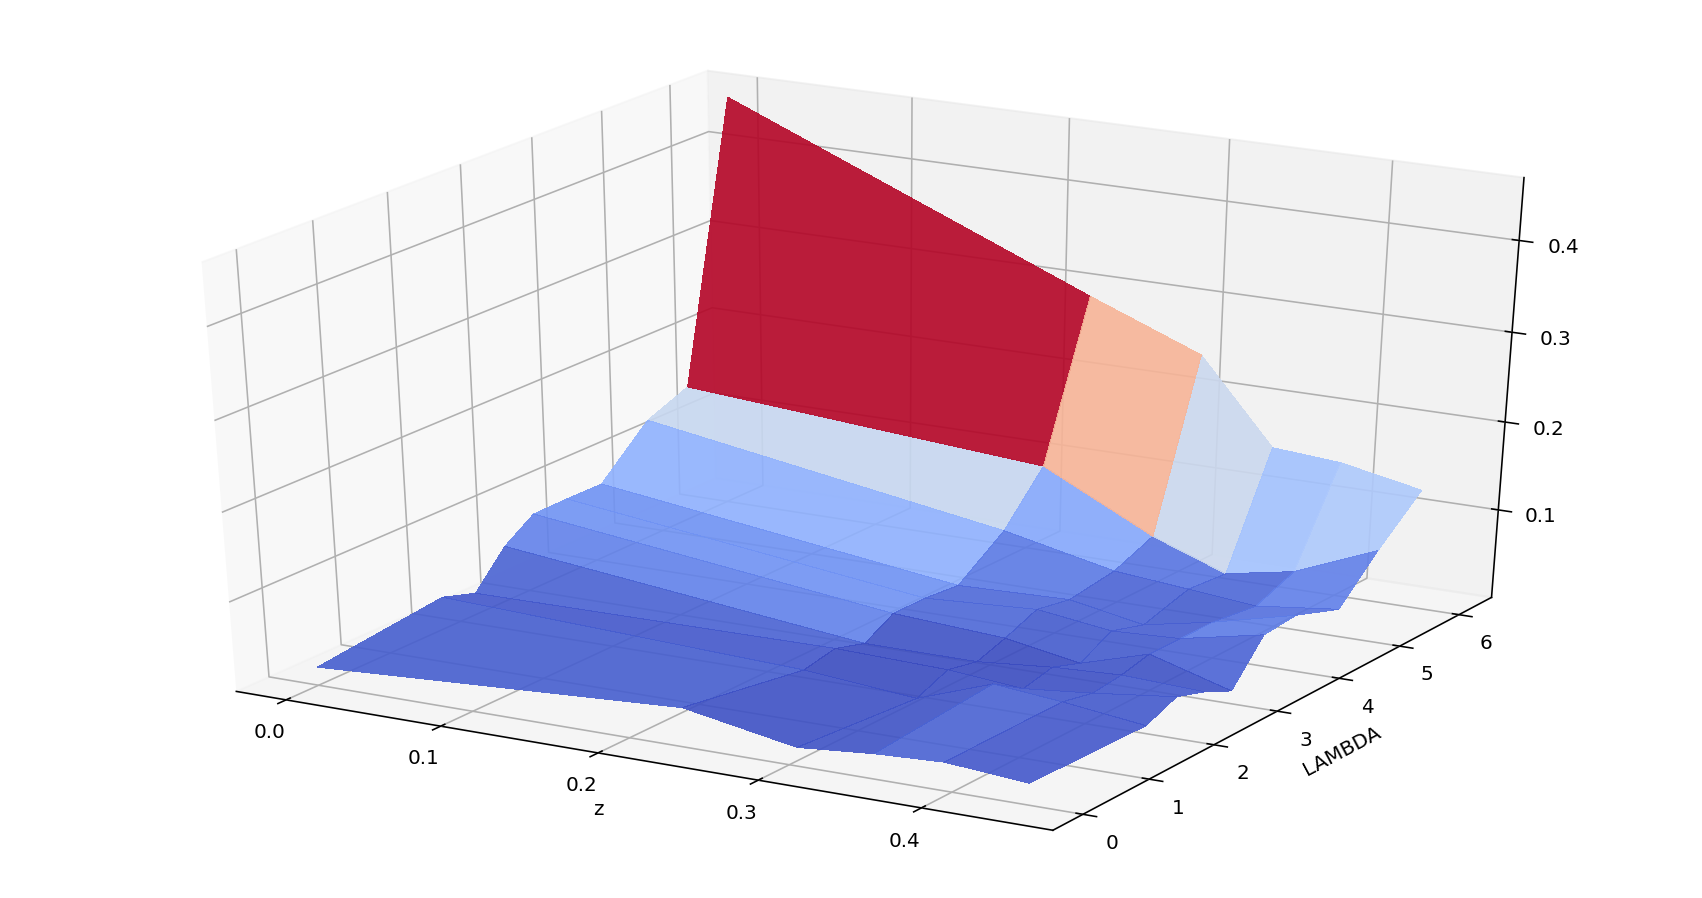

In [32]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15, 8))
X, Y = np.meshgrid(q_z[:-1], q_m[:-1])

Z = np.zeros_like(X)

ax.set_zticks(np.arange(0, 1.1, 0.1))
cols = list(recalls)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i,j] = recalls[cols[j]].iloc[i]
#X, Y = np.meshgrid(list(range(len(q_z) - 1)), list(range(len(q_m) - 1)))
        
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                       linewidth=0, antialiased=False, alpha=0.9)

# Customize the z axis.
#ax.set_zlim(0, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_xlabel('z')
ax.set_ylabel('LAMBDA')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [66]:
def m500_z_graph(cat_name, det_name, q_rat=0.1):
    df = pd.read_csv(cat_name)
    df = df[df['status'] != 'fn']
    df.index = np.arange(len(df))
    
    true_cats = {'planck_z' : pd.read_csv('/home/rt2122/Data/clusters/planck_z.csv'),
                'MCXCwp' : pd.read_csv('/home/rt2122/Data/clusters/mcxcwp.csv'),
                'ACTwp' : pd.read_csv('/home/rt2122/Data/clusters/actwp.csv')
                #'MCXC' : pd.read_csv('/home/rt2122/Data/original_catalogs/csv/MCXC.csv'),
                #'ACT' : pd.read_csv('/home/rt2122/Data/original_catalogs/csv/ACT.csv')
                }
    true_sc = {key : SkyCoord(ra=np.array(true_cats[key]['RA']) * u.degree, 
                              dec=np.array(true_cats[key]['DEC']) * u.degree, frame='icrs') for key in true_cats}
    
    q = df[df['catalog'] == 'planck_z']['max_pred'].quantile(q_rat)
    sc = SkyCoord(ra=np.array(df['RA']) * u.degree, dec=np.array(df['DEC']) * u.degree, frame='icrs')
    
    for name in true_cats:
        idx, d2d, _ = true_sc[name].match_to_catalog_sky(sc)
        true_cats[name]['max_pred'] = 0
        true_cats[name]['max_pred'] = np.array(df['max_pred'][idx])
        matched = d2d.degree < (400 / 3600)
        #matched = d2d.degree < (400000 / 3600)
        true_cats[name] = true_cats[name][matched]
        true_cats[name].index = np.arange(len(true_cats[name]))
    
    #_, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
    _, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
    for i, (st, en) in enumerate([[0, 1]]):#, [q, 1]]):
        for name, c in zip(true_cats, ['b', 'r', 'c']):
            cur_cat = true_cats[name]
            match_max_pred = np.logical_and(st <= cur_cat['max_pred'], cur_cat['max_pred'] <= en)
            #s = ax[i].scatter(cur_cat[match_max_pred]['z'], cur_cat[match_max_pred]['M500'], c=c, alpha=0.2)
            s = ax.scatter(cur_cat[match_max_pred]['z'], cur_cat[match_max_pred]['M500'], c=c, alpha=0.2)
            #s.set_label('matches with {} and {} \nin max_pred [{:.2f}, {:.2f}]'.format(name, det_name, st , en))
            s.set_label(name)
            plt.yscale('log')
        
        #ax[i].set_ylim(10**-1, 20)
        #ax[i].set_xlabel('z')
        #ax[i].set_ylabel('M500')
        #ax[i].grid(which='minor', axis='both', linestyle='--')
        #ax[i].grid(which='major', axis='both', linestyle='--')
        #ax[i].legend()
        ax.set_ylim(10**-1, 20)
        ax.set_xlabel('z')
        ax.set_ylabel('M500')
        ax.grid(which='minor', axis='both', linestyle='--')
        ax.grid(which='major', axis='both', linestyle='--')
        ax.legend()

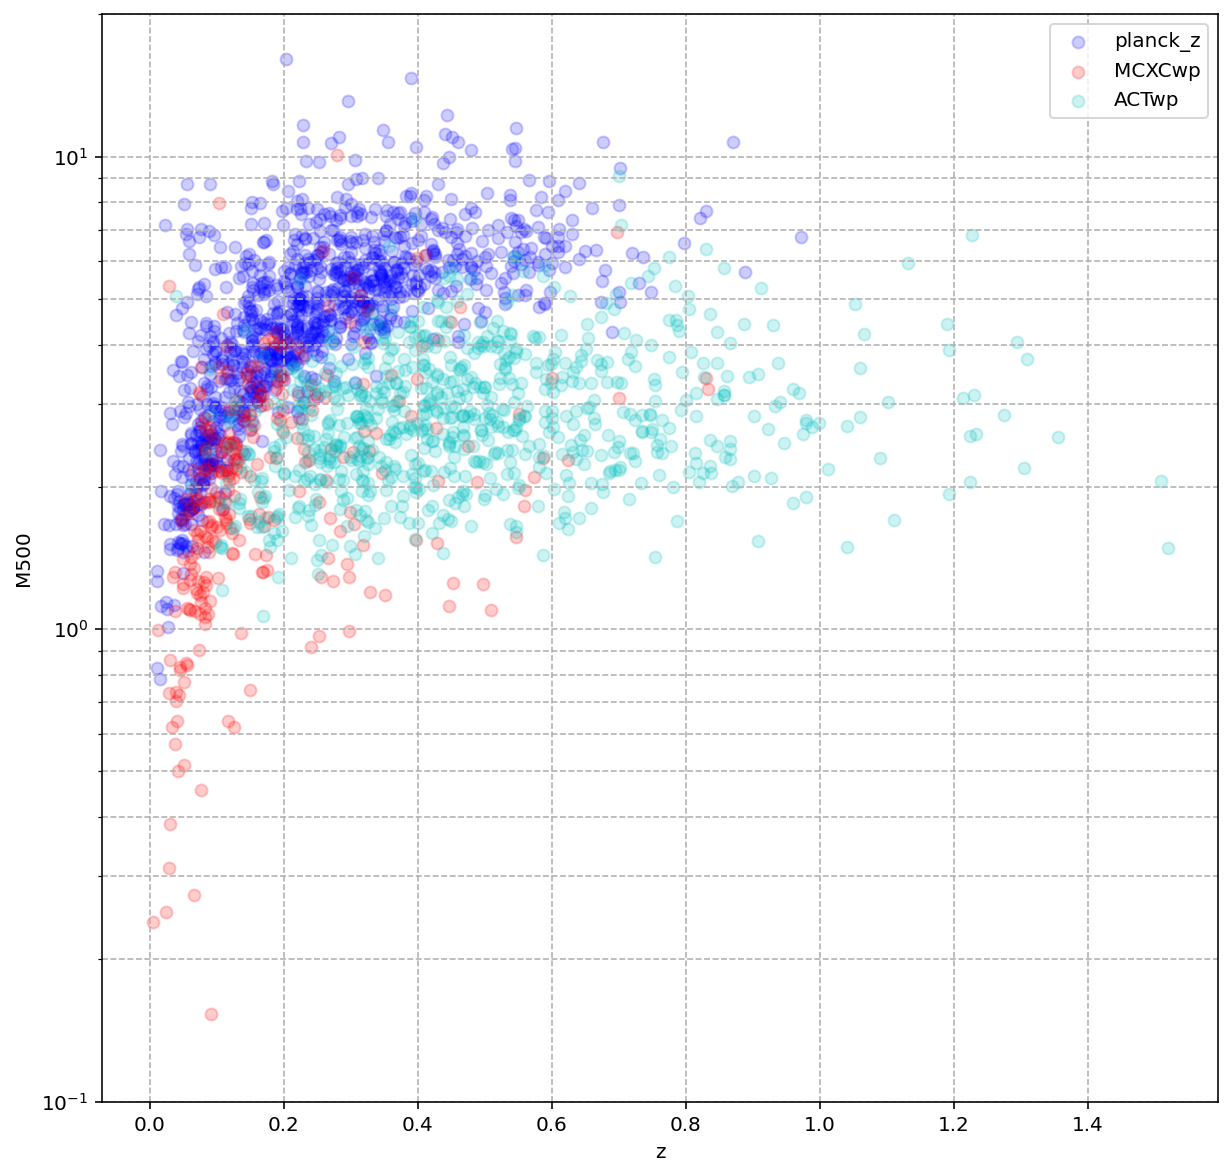

In [67]:
m500_z_graph('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv', 'pz_all_found34')

/home/rt2122/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


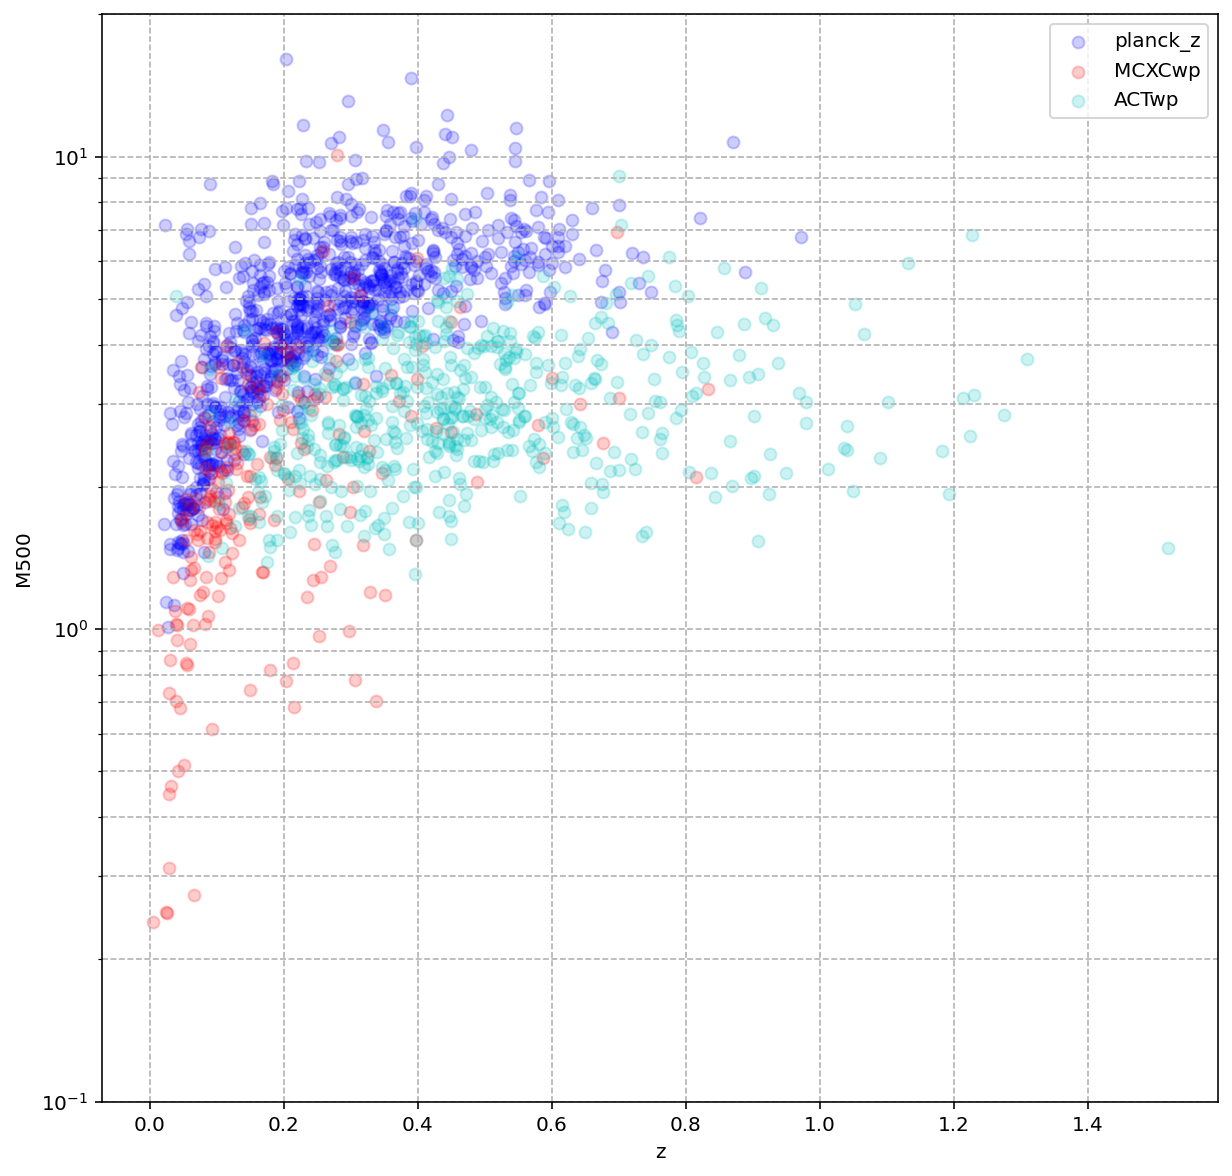

In [68]:
df = rematch_cat('/home/rt2122/Data/SRGz/brcat.csv')
df['max_pred'] /= df['max_pred'].max()
df.to_csv('/home/rt2122/Data/SRGz/brcat_rematched.csv', index=False)
m500_z_graph('/home/rt2122/Data/SRGz/brcat_rematched.csv', 'brcat')

In [69]:
pzall = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv')
brcat = pd.read_csv('/home/rt2122/Data/SRGz/brcat.csv')
pz_sc = SkyCoord(ra=np.array(pzall['RA'])*u.degree, dec=np.array(pzall['DEC'])*u.degree, frame='icrs')
br_sc = SkyCoord(ra=np.array(brcat['RA'])*u.degree, dec=np.array(brcat['DEC'])*u.degree, frame='icrs')
_, d2d, _ = pz_sc.match_to_catalog_sky(br_sc)
matched = d2d.degree > 5/60
pzall[matched].to_csv('/home/rt2122/Data/SRGz/dif.csv', index=False)

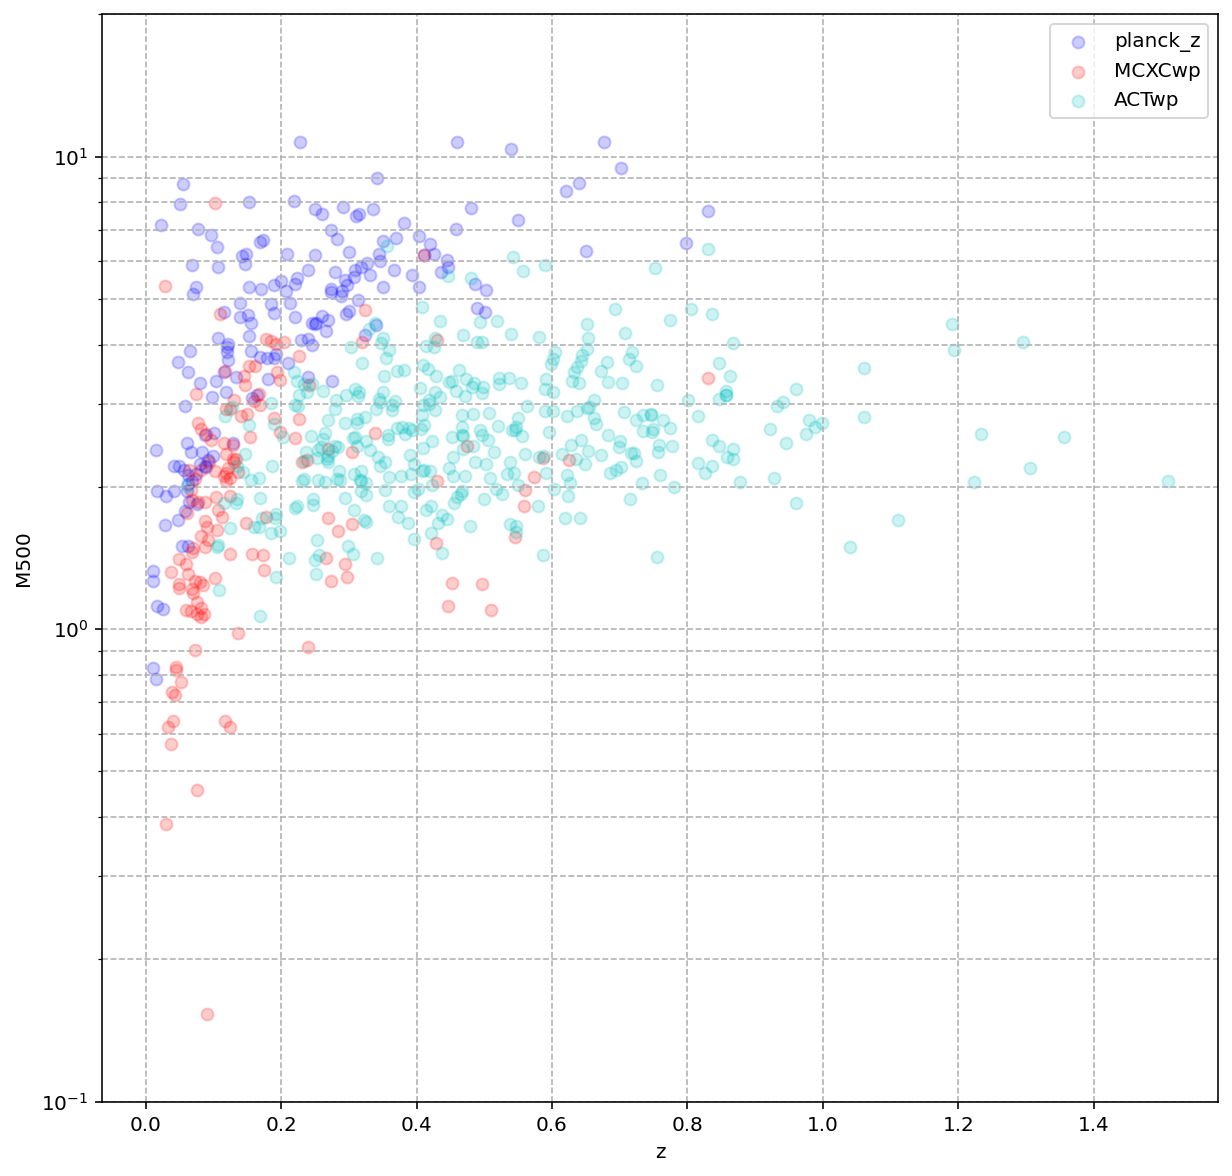

In [70]:
m500_z_graph('/home/rt2122/Data/SRGz/dif.csv', 'dif')